<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [27]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
import tensorflow as tf
import tensorflow_addons as tfa
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/KaggleImageData/UfukHocaVeri', output="output", seed=1337, ratio=(.7, 0.1,0.2)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 193 files [00:00, 422.33 files/s]


In [31]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [33]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [34]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=5)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [35]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=40,
                                                        width_shift_range=0.2,
                                                        height_shift_range=0.2,
                                                        zoom_range=0.2,
                                                        shear_range=0.2,
                                                        horizontal_flip=True,
                                                        fill_mode='nearest')# with data augmentation for train set
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [36]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch=32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.Accuracy(),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.Accuracy(),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.Accuracy(),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('DR.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [37]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [38]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 145ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 28.2824 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	28.28240394592285 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[28.28240394592285, 0.0, 0.0, 0.0, 0.0]



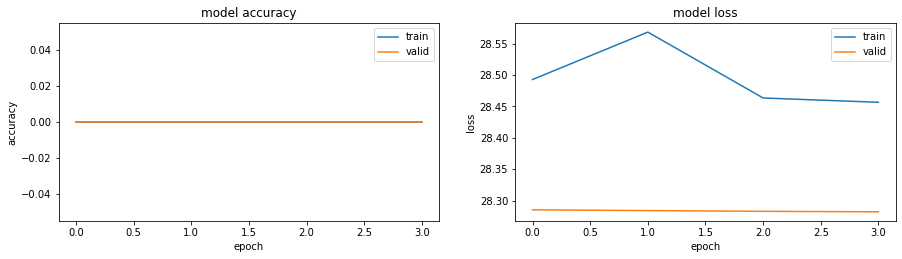


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 160ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 35ms/step - loss: 53.3517 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	53.3516960144043 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[53.3516960144043, 0.0, 0.0, 0.0, 0.0]



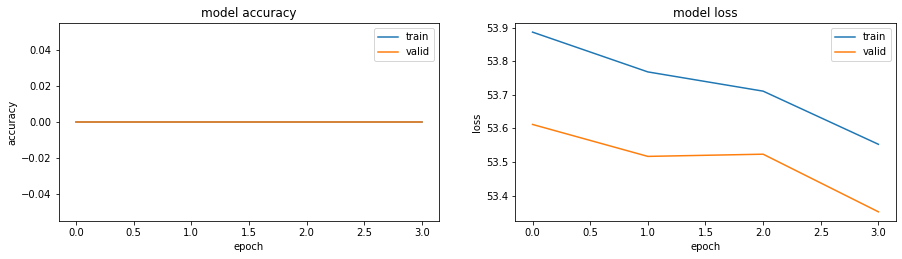


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 2.6112 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.0625 - f1_score: 0.0500

LOSS:	2.6111526489257812 	 ACCURACY:	0.0 	 PRECISION:	1.0 	 RECALL:	0.0625 	 F1-SCORE:	0.05000000074505806
[2.6111526489257812, 0.0, 1.0, 0.0625, 0.05000000074505806]



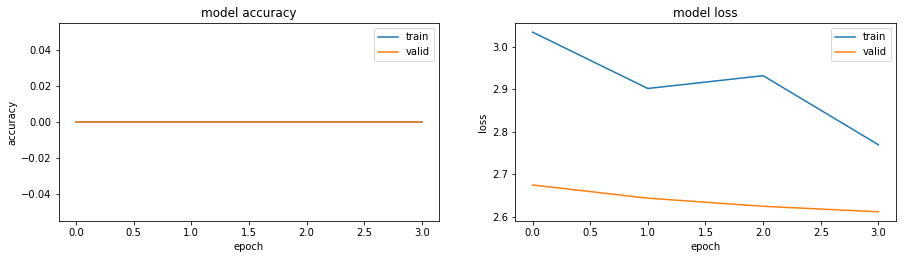


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 5.2642 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	5.264185905456543 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[5.264185905456543, 0.0, 0.0, 0.0, 0.0]



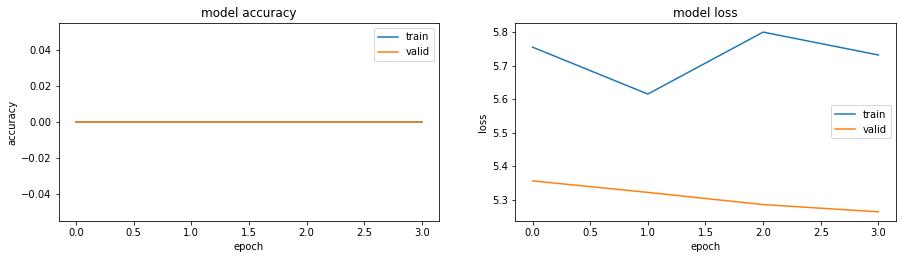


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 156ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 103.1425 - accuracy: 0.0000e+00 - precision: 0.3333 - recall: 0.1250 - f1_score: 0.0615

LOSS:	103.1424560546875 	 ACCURACY:	0.0 	 PRECISION:	0.3333333432674408 	 RECALL:	0.125 	 F1-SCORE:	0.061538465321063995
[103.1424560546875, 0.0, 0.3333333432674408, 0.125, 0.061538465321063995]



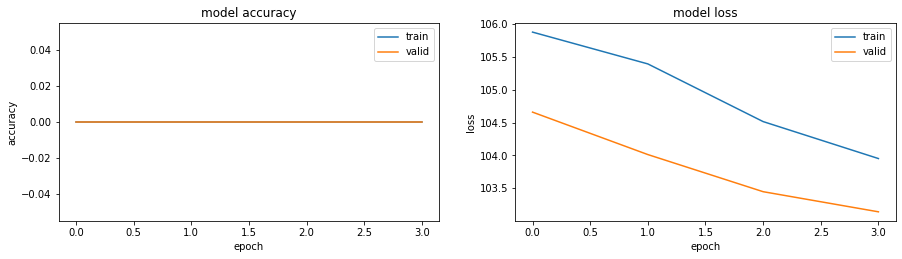




Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 185ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 54.2051 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	54.205078125 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[54.205078125, 0.0, 0.0, 0.0, 0.0]



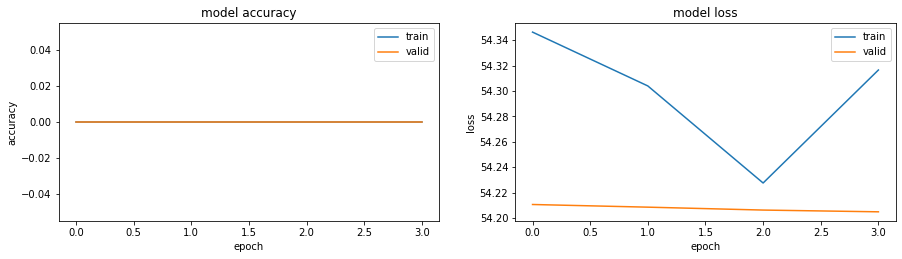


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 158ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 52.7296 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	52.72963333129883 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[52.72963333129883, 0.0, 0.0, 0.0, 0.0]



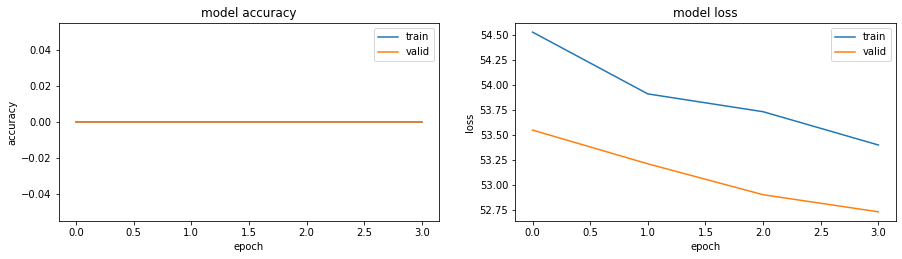


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 176ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 3.9309 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	3.930879592895508 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[3.930879592895508, 0.0, 0.0, 0.0, 0.0]



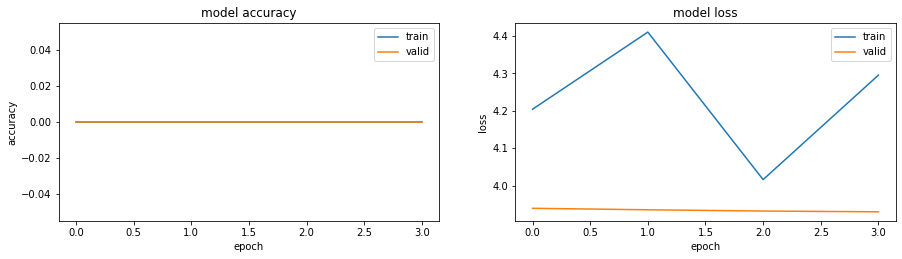


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 161ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 28.2292 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	28.229196548461914 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[28.229196548461914, 0.0, 0.0, 0.0, 0.0]



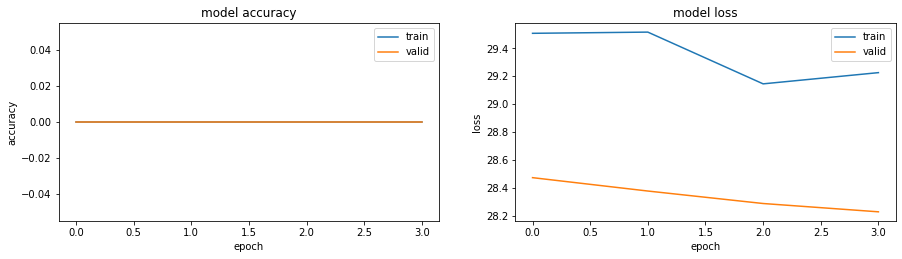


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 2.9483 - accuracy: 0.0000e+00 - precision: 0.4375 - recall: 0.4375 - f1_score: 0.1217

LOSS:	2.94834303855896 	 ACCURACY:	0.0 	 PRECISION:	0.4375 	 RECALL:	0.4375 	 F1-SCORE:	0.12173912674188614
[2.94834303855896, 0.0, 0.4375, 0.4375, 0.12173912674188614]



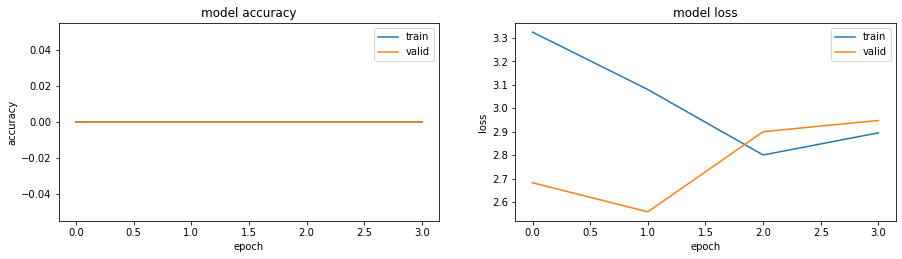


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 3.1548 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	3.154819965362549 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[3.154819965362549, 0.0, 0.0, 0.0, 0.0]



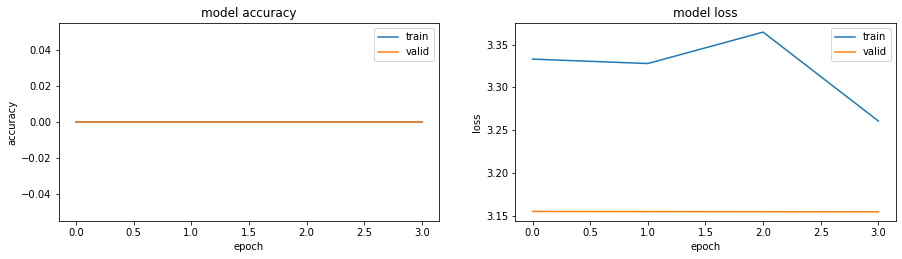


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 3.0212 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	3.02116060256958 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[3.02116060256958, 0.0, 0.0, 0.0, 0.0]



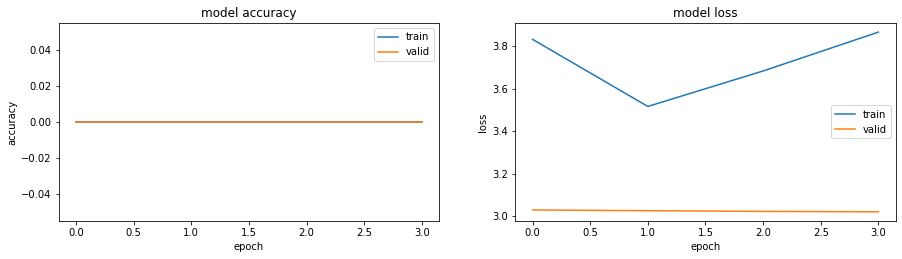


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 6.4443 - accuracy: 0.0000e+00 - precision: 0.4375 - recall: 0.4375 - f1_score: 0.1217

LOSS:	6.444305419921875 	 ACCURACY:	0.0 	 PRECISION:	0.4375 	 RECALL:	0.4375 	 F1-SCORE:	0.12173912674188614
[6.444305419921875, 0.0, 0.4375, 0.4375, 0.12173912674188614]



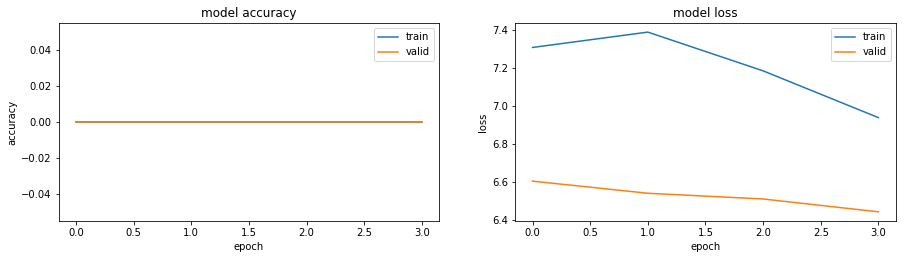


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 164ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 11.9015 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	11.901533126831055 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[11.901533126831055, 0.0, 0.0, 0.0, 0.0]



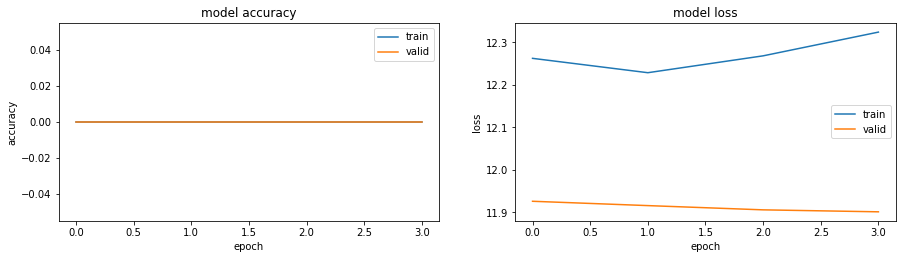


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 158ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 53.8972 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	53.89723587036133 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[53.89723587036133, 0.0, 0.0, 0.0, 0.0]



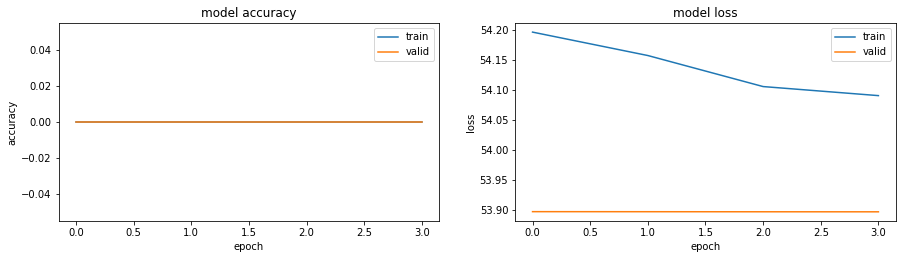


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 164ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 2.0602 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.0601887702941895 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.0601887702941895, 0.0, 0.0, 0.0, 0.0]



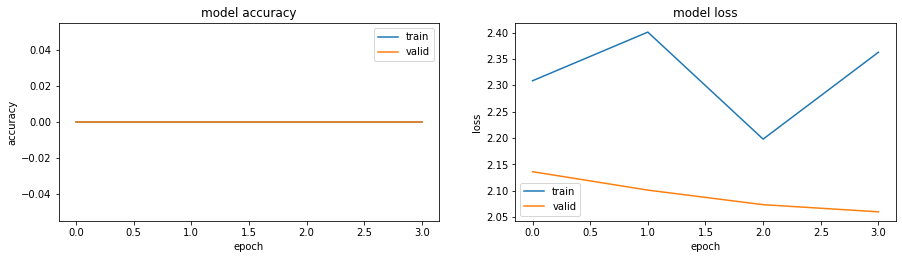


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 2.0042 - accuracy: 0.0000e+00 - precision: 0.2500 - recall: 0.2500 - f1_score: 0.0800

LOSS:	2.0042409896850586 	 ACCURACY:	0.0 	 PRECISION:	0.25 	 RECALL:	0.25 	 F1-SCORE:	0.07999999821186066
[2.0042409896850586, 0.0, 0.25, 0.25, 0.07999999821186066]



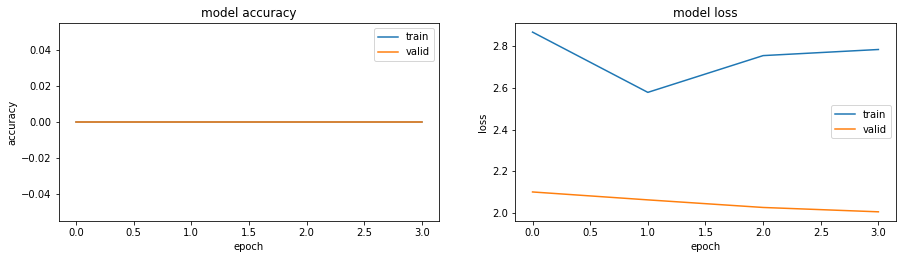


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 158ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 105.2461 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	105.24612426757812 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[105.24612426757812, 0.0, 0.0, 0.0, 0.0]



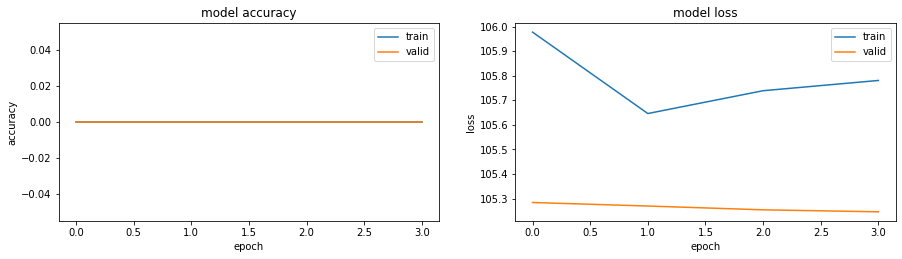


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 176ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 28.4581 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.0625 - f1_score: 0.1333

LOSS:	28.458131790161133 	 ACCURACY:	0.0 	 PRECISION:	1.0 	 RECALL:	0.0625 	 F1-SCORE:	0.13333334028720856
[28.458131790161133, 0.0, 1.0, 0.0625, 0.13333334028720856]



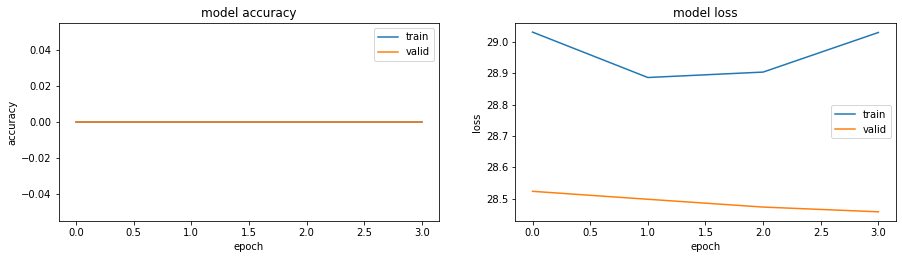


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 28.1120 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	28.112001419067383 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[28.112001419067383, 0.0, 0.0, 0.0, 0.0]



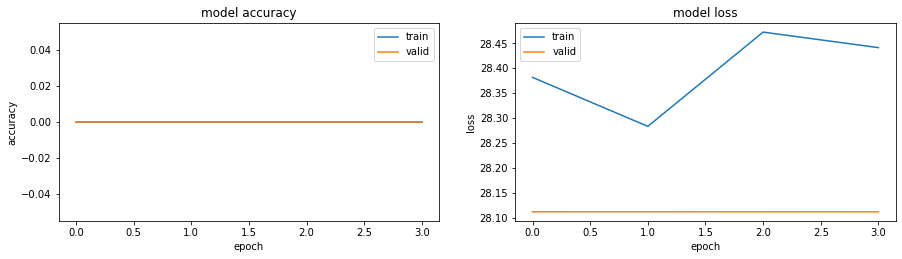


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 161ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 2.0458 - accuracy: 0.0000e+00 - precision: 0.6364 - recall: 0.4375 - f1_score: 0.1556

LOSS:	2.045809268951416 	 ACCURACY:	0.0 	 PRECISION:	0.6363636255264282 	 RECALL:	0.4375 	 F1-SCORE:	0.15555556118488312
[2.045809268951416, 0.0, 0.6363636255264282, 0.4375, 0.15555556118488312]



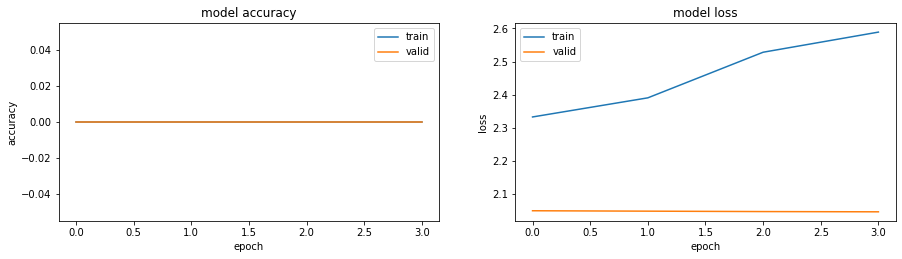


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 178ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 41ms/step - loss: 104.9529 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	104.95291137695312 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[104.95291137695312, 0.0, 0.0, 0.0, 0.0]



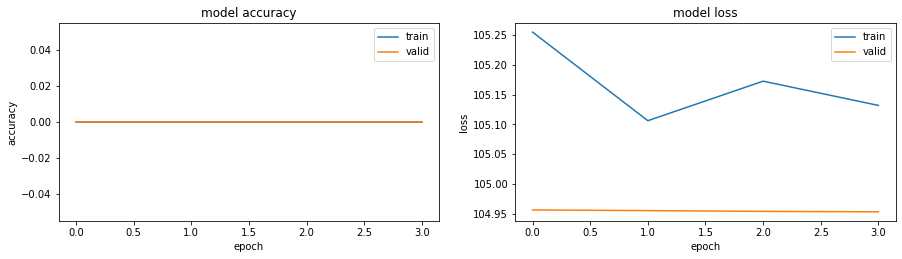


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 1.7077 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.7076629400253296 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.7076629400253296, 0.0, 0.0, 0.0, 0.0]



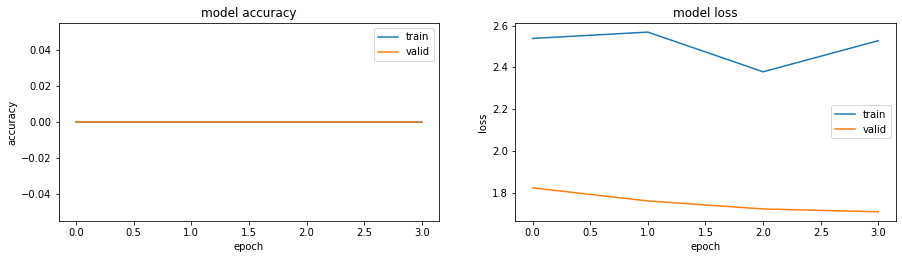


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 12.2245 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	12.224520683288574 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[12.224520683288574, 0.0, 0.0, 0.0, 0.0]



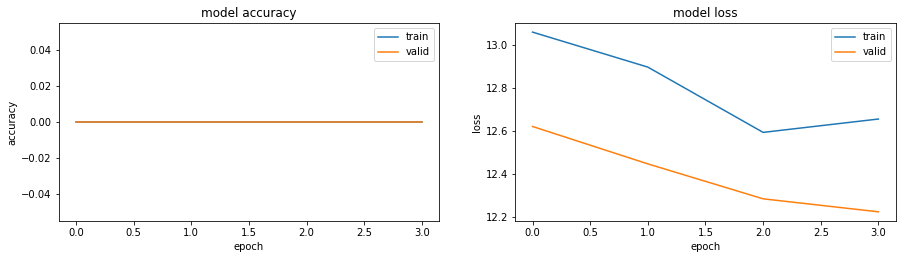


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 2.8171 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.8171274662017822 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.8171274662017822, 0.0, 0.0, 0.0, 0.0]



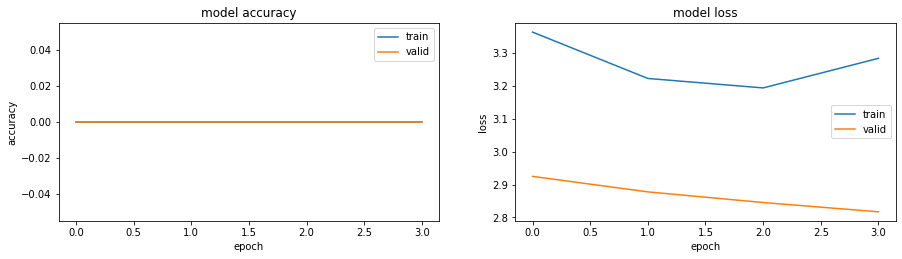


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 158ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 53.4677 - accuracy: 0.0000e+00 - precision: 0.3750 - recall: 0.1875 - f1_score: 0.0800

LOSS:	53.46772384643555 	 ACCURACY:	0.0 	 PRECISION:	0.375 	 RECALL:	0.1875 	 F1-SCORE:	0.07999999821186066
[53.46772384643555, 0.0, 0.375, 0.1875, 0.07999999821186066]



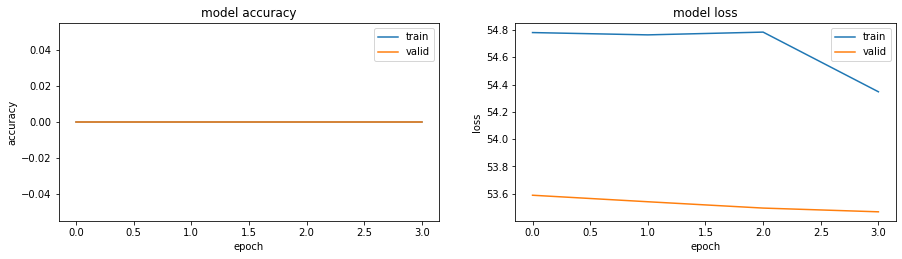


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 104.9537 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	104.9537353515625 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[104.9537353515625, 0.0, 0.0, 0.0, 0.0]



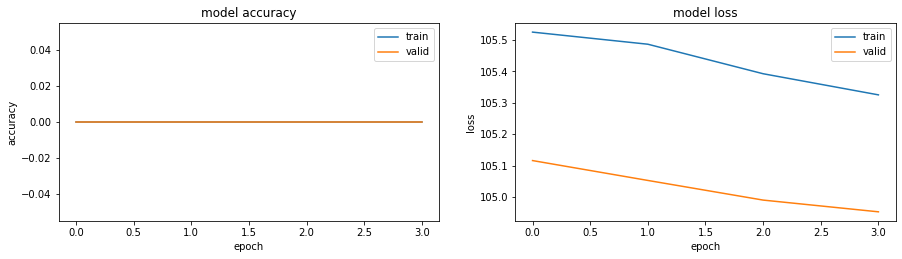


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 2.0e+00 3.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 1.6070 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.6070218086242676 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.6070218086242676, 0.0, 0.0, 0.0, 0.0]



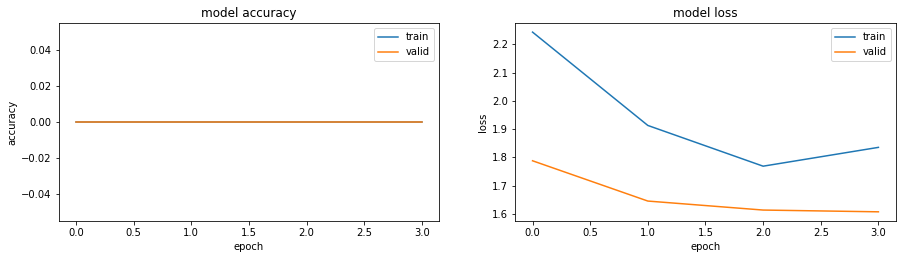


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 158ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 7.0791 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	7.0790863037109375 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[7.0790863037109375, 0.0, 0.0, 0.0, 0.0]



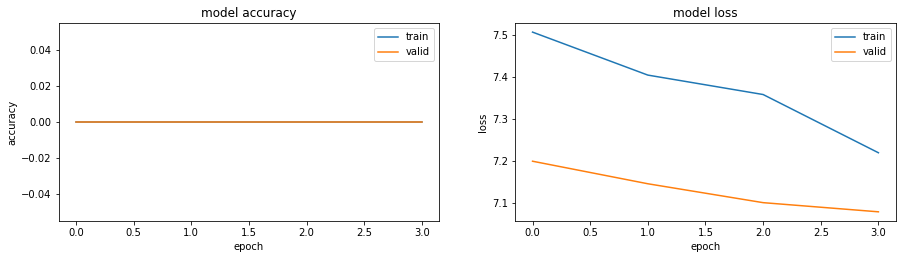


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 1.0e+00 7.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 175ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 1.9558 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.9558314085006714 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.9558314085006714, 0.0, 0.0, 0.0, 0.0]



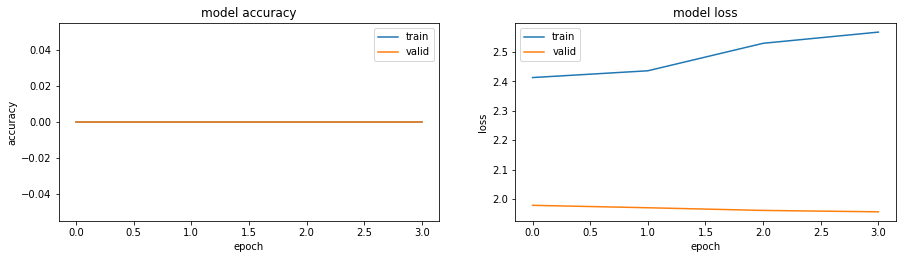


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 1.00e+00 5.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 22.6912 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	22.691165924072266 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[22.691165924072266, 0.0, 0.0, 0.0, 0.0]



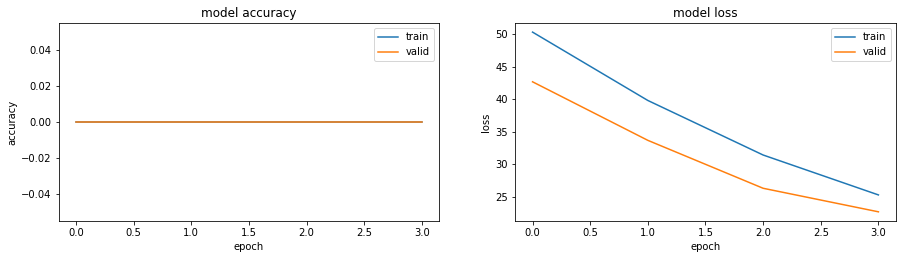


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 1.9711 - accuracy: 0.0000e+00 - precision: 0.2000 - recall: 0.0625 - f1_score: 0.0333

LOSS:	1.9710566997528076 	 ACCURACY:	0.0 	 PRECISION:	0.20000000298023224 	 RECALL:	0.0625 	 F1-SCORE:	0.03333333507180214
[1.9710566997528076, 0.0, 0.20000000298023224, 0.0625, 0.03333333507180214]



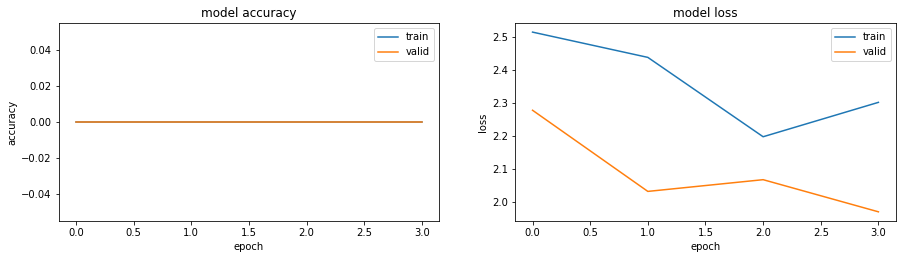


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 158ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 1.9608 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.960811734199524 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.960811734199524, 0.0, 0.0, 0.0, 0.0]



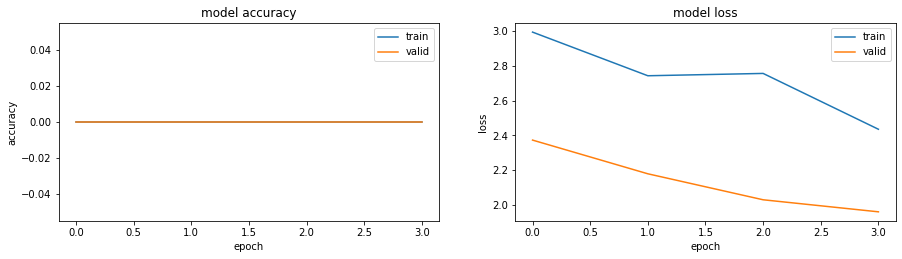


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 198ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 75ms/step - loss: 58.4868 - accuracy: 0.0000e+00 - precision: 0.4375 - recall: 0.4375 - f1_score: 0.1217

LOSS:	58.4868278503418 	 ACCURACY:	0.0 	 PRECISION:	0.4375 	 RECALL:	0.4375 	 F1-SCORE:	0.12173912674188614
[58.4868278503418, 0.0, 0.4375, 0.4375, 0.12173912674188614]



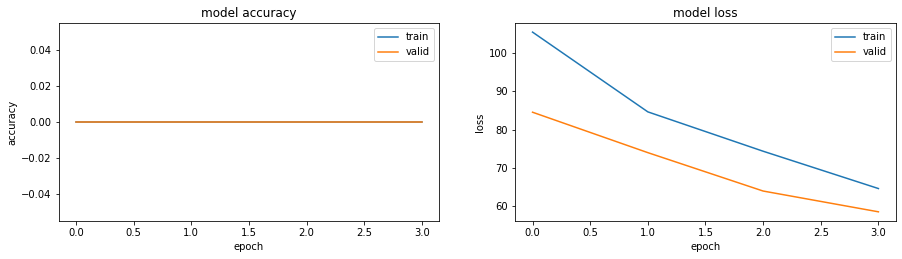


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 428ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 1.7630 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.0625 - f1_score: 0.1333

LOSS:	1.7629995346069336 	 ACCURACY:	0.0 	 PRECISION:	1.0 	 RECALL:	0.0625 	 F1-SCORE:	0.13333334028720856
[1.7629995346069336, 0.0, 1.0, 0.0625, 0.13333334028720856]



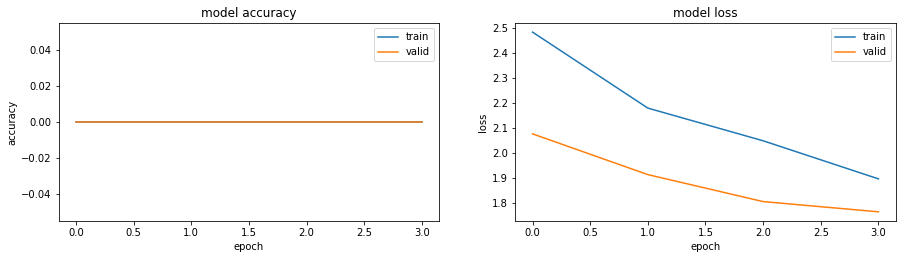


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 159ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 6.9420 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	6.941957473754883 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[6.941957473754883, 0.0, 0.0, 0.0, 0.0]



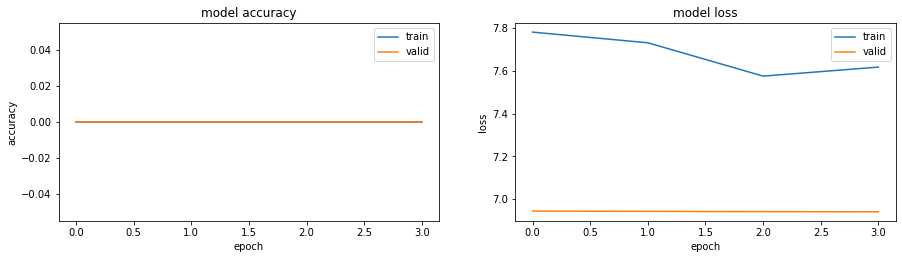


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 176ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 1.9820 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.9820261001586914 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.9820261001586914, 0.0, 0.0, 0.0, 0.0]



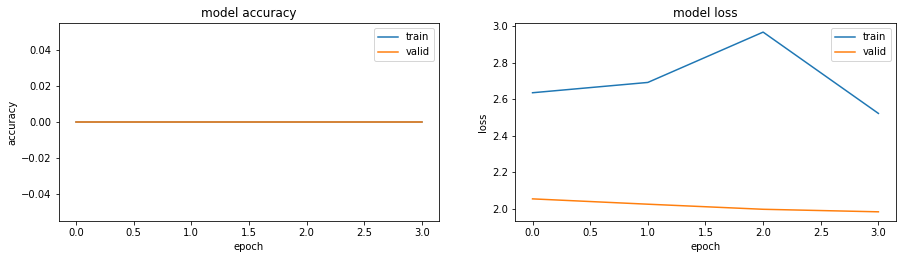


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-01 2.0e+00 5.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 15.0565 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.0625 - f1_score: 0.0500

LOSS:	15.056519508361816 	 ACCURACY:	0.0 	 PRECISION:	1.0 	 RECALL:	0.0625 	 F1-SCORE:	0.05000000074505806
[15.056519508361816, 0.0, 1.0, 0.0625, 0.05000000074505806]



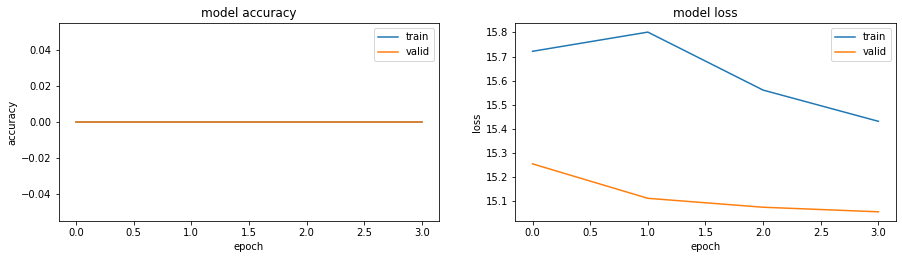


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 161ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 2.8991 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.8991246223449707 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.8991246223449707, 0.0, 0.0, 0.0, 0.0]



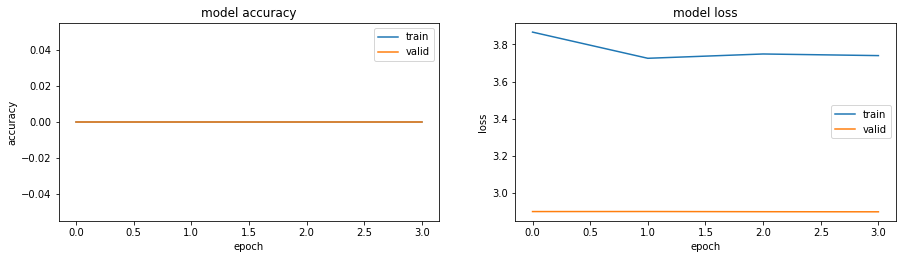


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 2.5458 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.545846939086914 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.545846939086914, 0.0, 0.0, 0.0, 0.0]



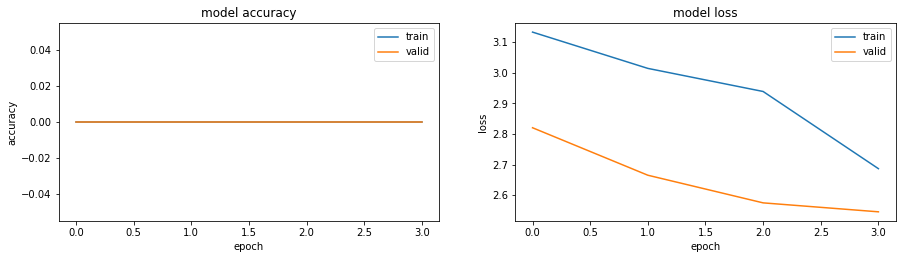


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 174ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 105.4784 - accuracy: 0.0000e+00 - precision: 0.4375 - recall: 0.4375 - f1_score: 0.1217

LOSS:	105.4784164428711 	 ACCURACY:	0.0 	 PRECISION:	0.4375 	 RECALL:	0.4375 	 F1-SCORE:	0.12173912674188614
[105.4784164428711, 0.0, 0.4375, 0.4375, 0.12173912674188614]



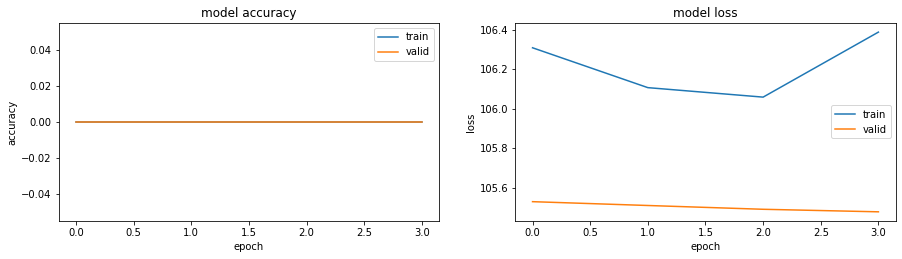


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 12.8714 - accuracy: 0.0000e+00 - precision: 0.2500 - recall: 0.2500 - f1_score: 0.0800

LOSS:	12.871408462524414 	 ACCURACY:	0.0 	 PRECISION:	0.25 	 RECALL:	0.25 	 F1-SCORE:	0.07999999821186066
[12.871408462524414, 0.0, 0.25, 0.25, 0.07999999821186066]



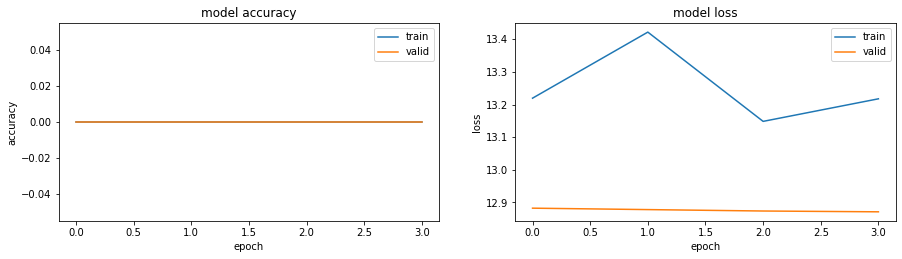


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 54.2805 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	54.28053283691406 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[54.28053283691406, 0.0, 0.0, 0.0, 0.0]



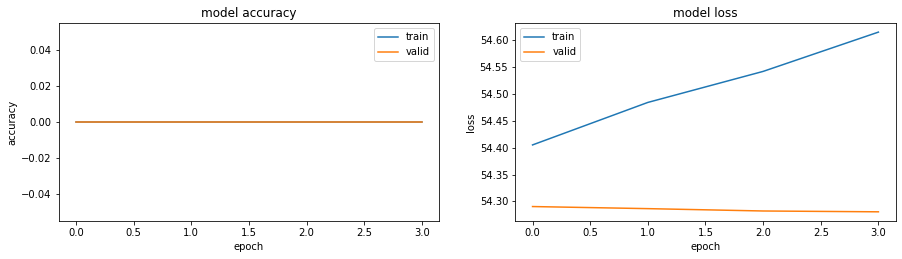


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 2.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 2.6716 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.671586751937866 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.671586751937866, 0.0, 0.0, 0.0, 0.0]



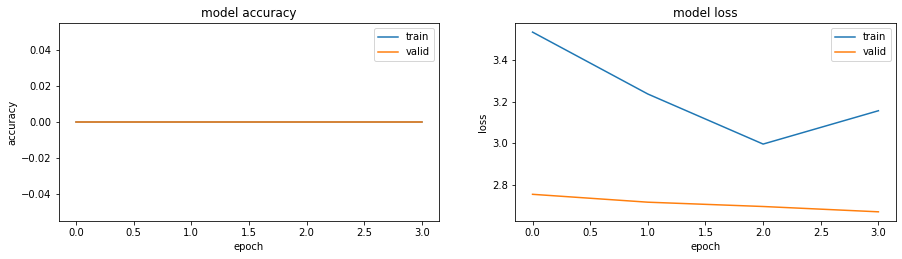


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 174ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 54.1795 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	54.179508209228516 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[54.179508209228516, 0.0, 0.0, 0.0, 0.0]



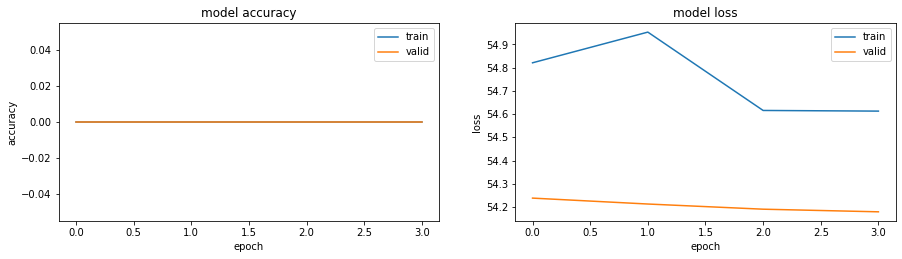


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 2.0e+00 3.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 37ms/step - loss: 1.9716 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.971632480621338 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.971632480621338, 0.0, 0.0, 0.0, 0.0]



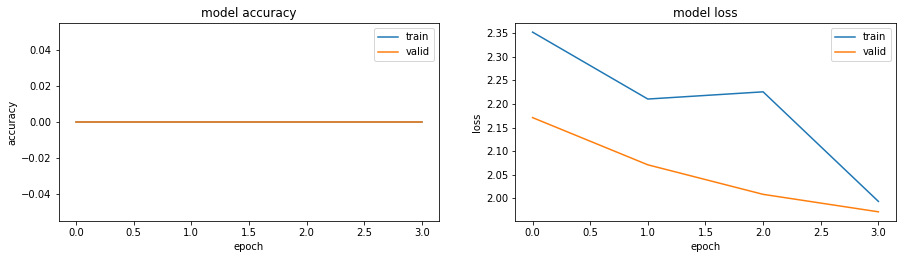


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 170ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 104.3276 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	104.32756042480469 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[104.32756042480469, 0.0, 0.0, 0.0, 0.0]



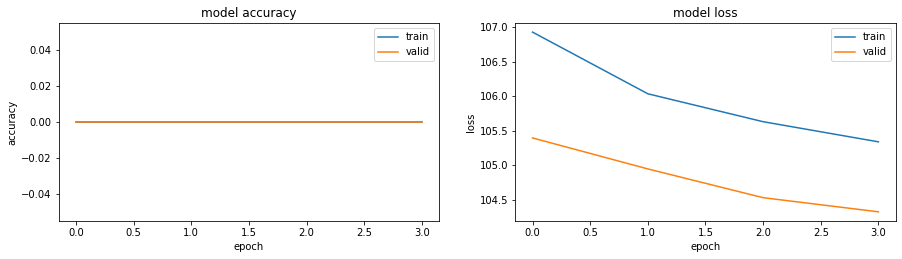


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 157ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 2.4751 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.4750778675079346 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.4750778675079346, 0.0, 0.0, 0.0, 0.0]



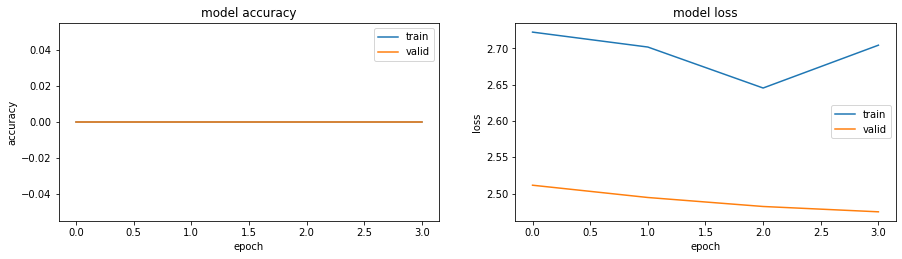


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 2.4381 - accuracy: 0.0000e+00 - precision: 0.2500 - recall: 0.2500 - f1_score: 0.0800

LOSS:	2.438117027282715 	 ACCURACY:	0.0 	 PRECISION:	0.25 	 RECALL:	0.25 	 F1-SCORE:	0.07999999821186066
[2.438117027282715, 0.0, 0.25, 0.25, 0.07999999821186066]



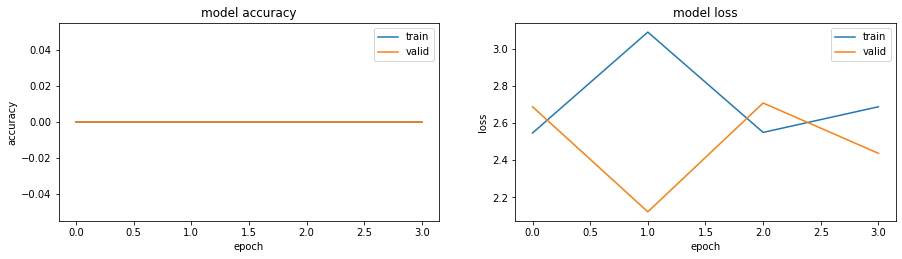


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 54.0831 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	54.08311080932617 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[54.08311080932617, 0.0, 0.0, 0.0, 0.0]



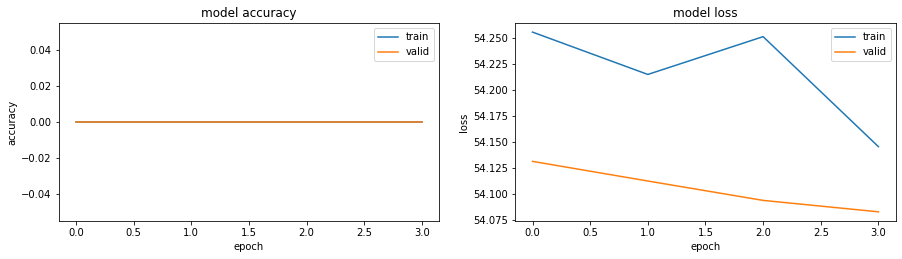


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 181ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 1.8748 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.874849557876587 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.874849557876587, 0.0, 0.0, 0.0, 0.0]



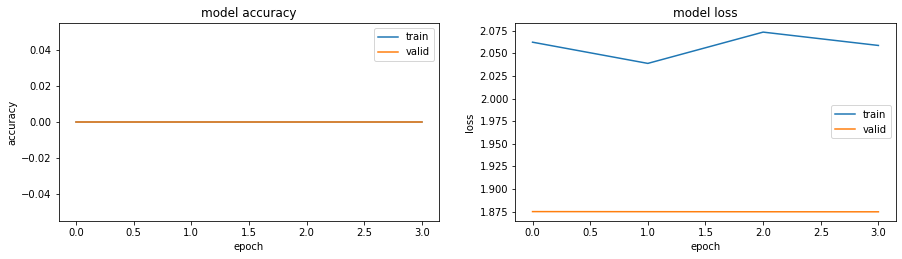


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 2.2343 - accuracy: 0.0000e+00 - precision: 0.4000 - recall: 0.1250 - f1_score: 0.0889

LOSS:	2.234330177307129 	 ACCURACY:	0.0 	 PRECISION:	0.4000000059604645 	 RECALL:	0.125 	 F1-SCORE:	0.08888889849185944
[2.234330177307129, 0.0, 0.4000000059604645, 0.125, 0.08888889849185944]



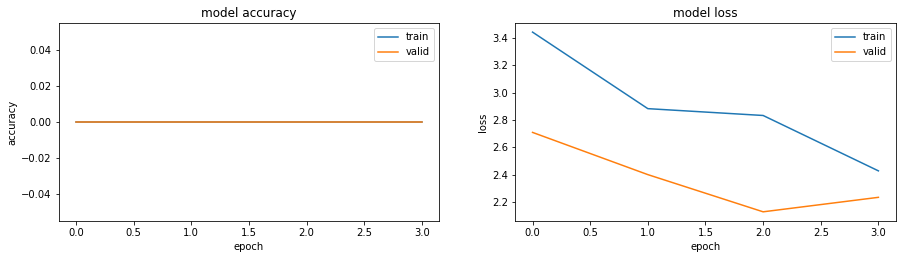


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 160ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 15.1625 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	15.16247844696045 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[15.16247844696045, 0.0, 0.0, 0.0, 0.0]



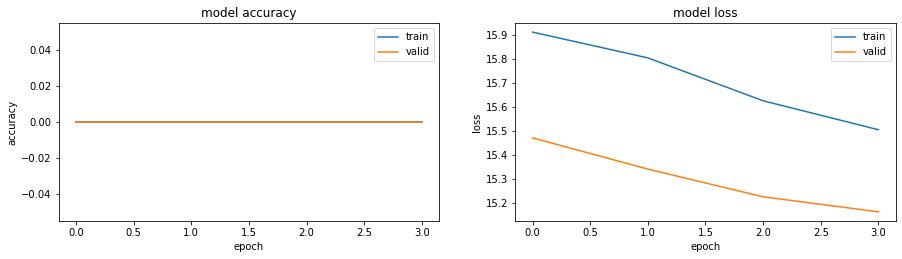


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 11.8406 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	11.840561866760254 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[11.840561866760254, 0.0, 0.0, 0.0, 0.0]



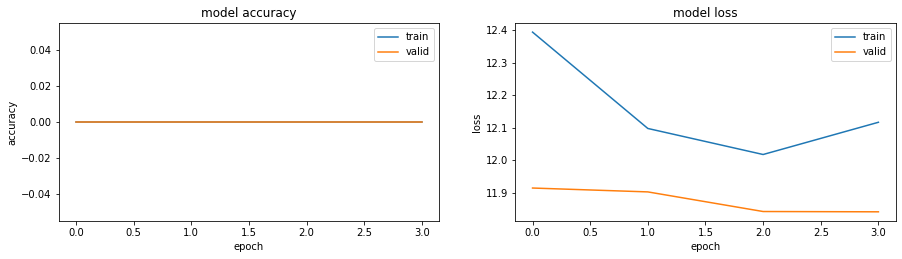


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 179ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 9.3489 - accuracy: 0.0000e+00 - precision: 0.6667 - recall: 0.2500 - f1_score: 0.1231

LOSS:	9.348925590515137 	 ACCURACY:	0.0 	 PRECISION:	0.6666666865348816 	 RECALL:	0.25 	 F1-SCORE:	0.12307693064212799
[9.348925590515137, 0.0, 0.6666666865348816, 0.25, 0.12307693064212799]



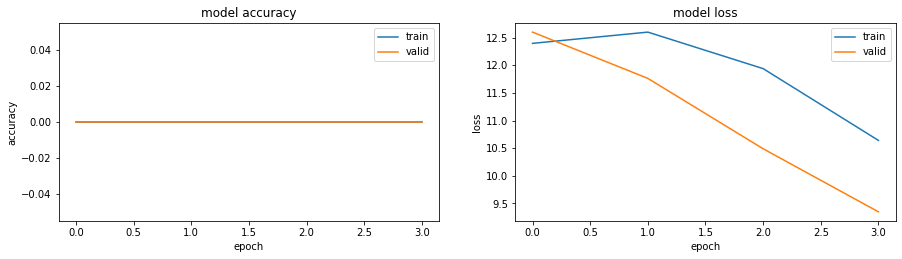


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 27.3726 - accuracy: 0.0000e+00 - precision: 0.5000 - recall: 0.1250 - f1_score: 0.0727

LOSS:	27.372600555419922 	 ACCURACY:	0.0 	 PRECISION:	0.5 	 RECALL:	0.125 	 F1-SCORE:	0.0727272778749466
[27.372600555419922, 0.0, 0.5, 0.125, 0.0727272778749466]



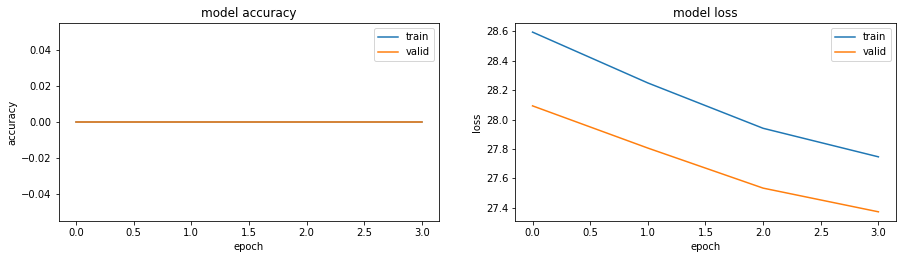


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 76.9485 - accuracy: 0.0000e+00 - precision: 0.1667 - recall: 0.1250 - f1_score: 0.0500

LOSS:	76.94849395751953 	 ACCURACY:	0.0 	 PRECISION:	0.1666666716337204 	 RECALL:	0.125 	 F1-SCORE:	0.05000000074505806
[76.94849395751953, 0.0, 0.1666666716337204, 0.125, 0.05000000074505806]



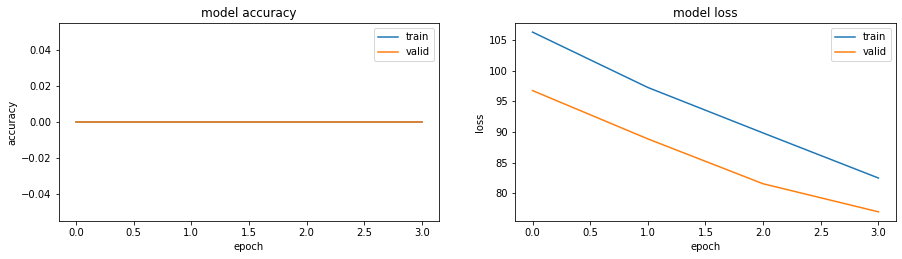


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 164ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 1.9277 - accuracy: 0.0000e+00 - precision: 0.7500 - recall: 0.3750 - f1_score: 0.1600

LOSS:	1.9277271032333374 	 ACCURACY:	0.0 	 PRECISION:	0.75 	 RECALL:	0.375 	 F1-SCORE:	0.1599999964237213
[1.9277271032333374, 0.0, 0.75, 0.375, 0.1599999964237213]



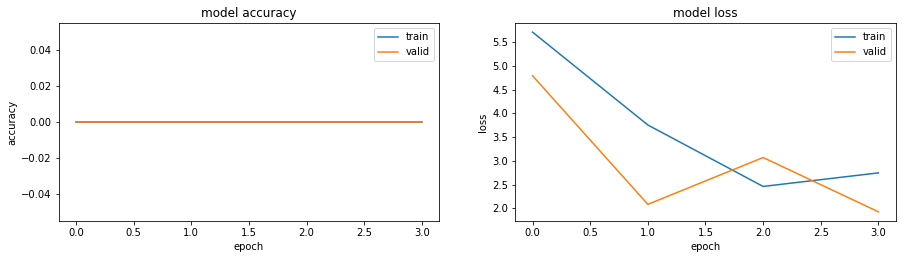


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 160ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 2.5799 - accuracy: 0.0000e+00 - precision: 0.2500 - recall: 0.2500 - f1_score: 0.0800

LOSS:	2.5799410343170166 	 ACCURACY:	0.0 	 PRECISION:	0.25 	 RECALL:	0.25 	 F1-SCORE:	0.07999999821186066
[2.5799410343170166, 0.0, 0.25, 0.25, 0.07999999821186066]



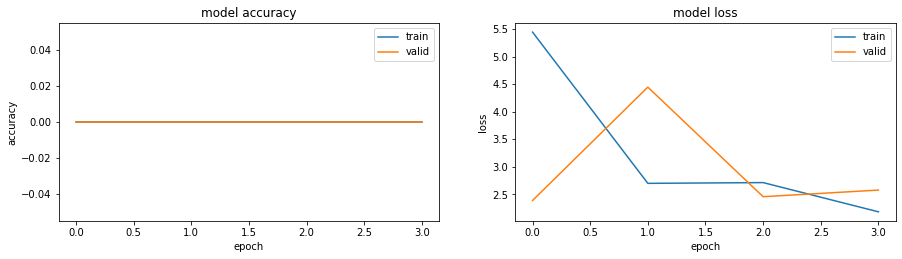


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 1.8440 - accuracy: 0.0000e+00 - precision: 0.5000 - recall: 0.3750 - f1_score: 0.1263

LOSS:	1.84398353099823 	 ACCURACY:	0.0 	 PRECISION:	0.5 	 RECALL:	0.375 	 F1-SCORE:	0.12631578743457794
[1.84398353099823, 0.0, 0.5, 0.375, 0.12631578743457794]



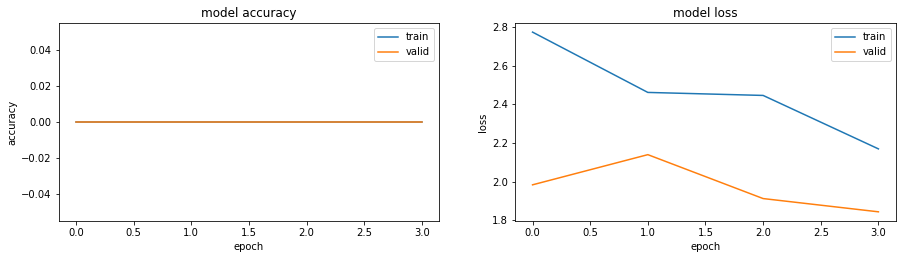


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 3.0981 - accuracy: 0.0000e+00 - precision: 0.1667 - recall: 0.1250 - f1_score: 0.0500

LOSS:	3.09805965423584 	 ACCURACY:	0.0 	 PRECISION:	0.1666666716337204 	 RECALL:	0.125 	 F1-SCORE:	0.05000000074505806
[3.09805965423584, 0.0, 0.1666666716337204, 0.125, 0.05000000074505806]



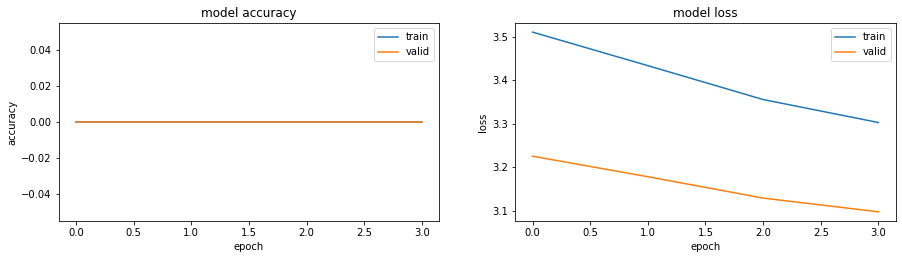


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 181ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 35ms/step - loss: 15.5353 - accuracy: 0.0000e+00 - precision: 0.5000 - recall: 0.3125 - f1_score: 0.1176

LOSS:	15.53525447845459 	 ACCURACY:	0.0 	 PRECISION:	0.5 	 RECALL:	0.3125 	 F1-SCORE:	0.11764706671237946
[15.53525447845459, 0.0, 0.5, 0.3125, 0.11764706671237946]



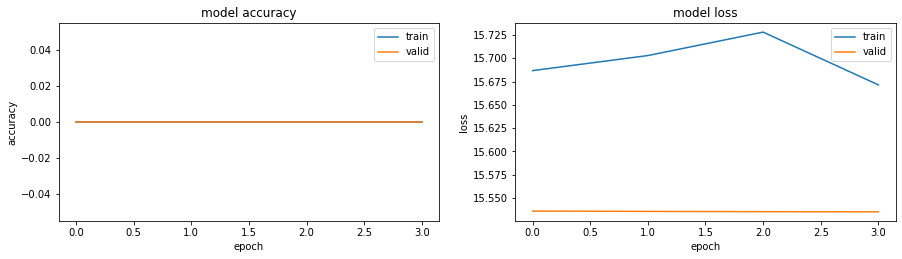


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 10.6492 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	10.649186134338379 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[10.649186134338379, 0.0, 0.0, 0.0, 0.0]



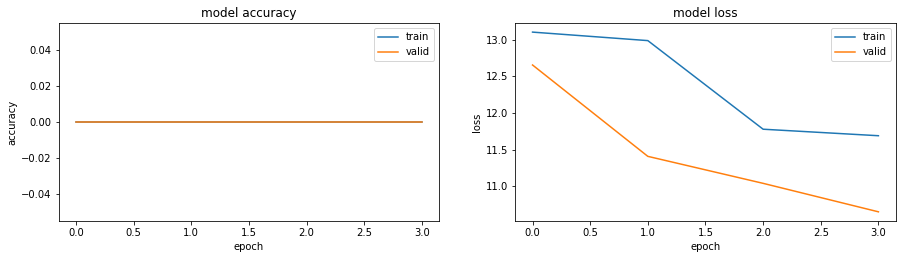


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 3.8316 - accuracy: 0.0000e+00 - precision: 0.5000 - recall: 0.1250 - f1_score: 0.0727

LOSS:	3.8315682411193848 	 ACCURACY:	0.0 	 PRECISION:	0.5 	 RECALL:	0.125 	 F1-SCORE:	0.0727272778749466
[3.8315682411193848, 0.0, 0.5, 0.125, 0.0727272778749466]



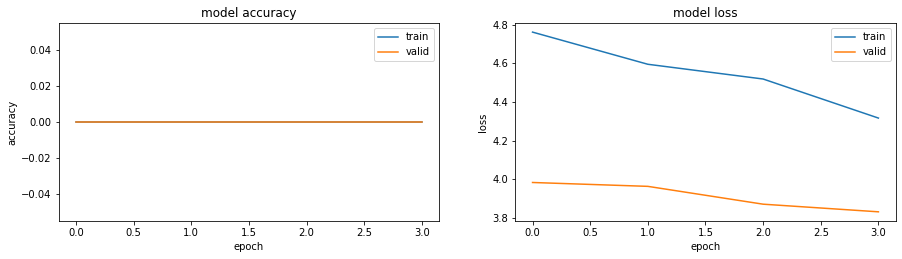


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 160ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 1.9159 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.9158599376678467 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.9158599376678467, 0.0, 0.0, 0.0, 0.0]



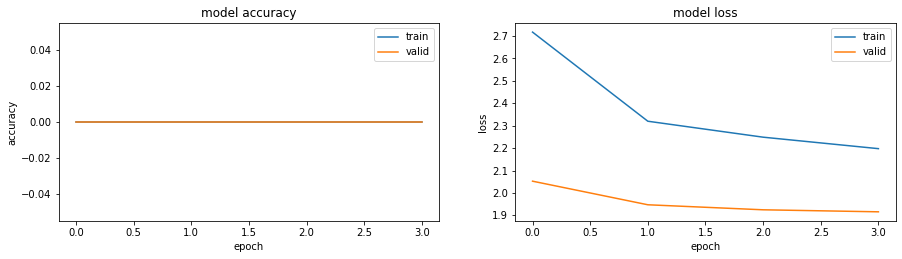


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 3.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 34ms/step - loss: 53.8009 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	53.80089569091797 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[53.80089569091797, 0.0, 0.0, 0.0, 0.0]



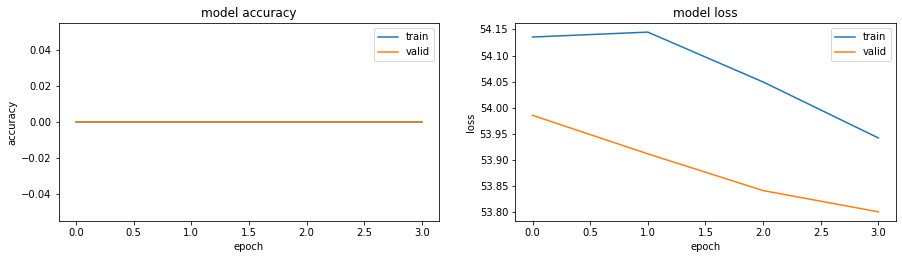


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 7.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 40ms/step - loss: 11.3748 - accuracy: 0.0000e+00 - precision: 0.6250 - recall: 0.3125 - f1_score: 0.1333

LOSS:	11.374801635742188 	 ACCURACY:	0.0 	 PRECISION:	0.625 	 RECALL:	0.3125 	 F1-SCORE:	0.13333334028720856
[11.374801635742188, 0.0, 0.625, 0.3125, 0.13333334028720856]



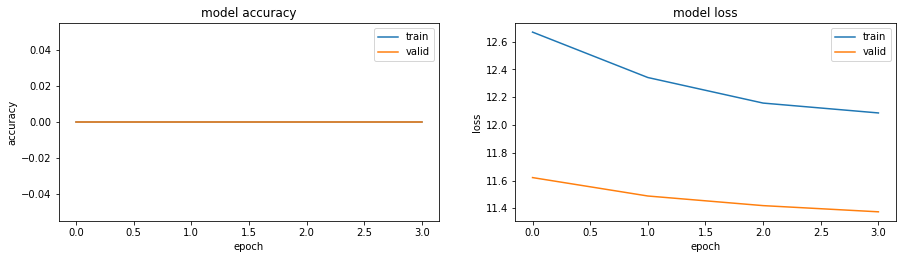


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 3.1766 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	3.1766068935394287 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[3.1766068935394287, 0.0, 0.0, 0.0, 0.0]



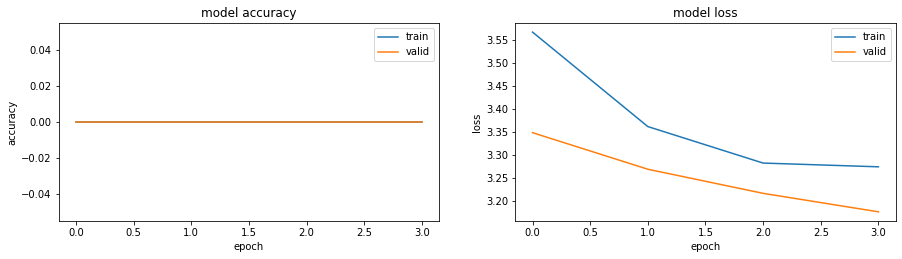


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 180ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 7.6170 - accuracy: 0.0000e+00 - precision: 0.1111 - recall: 0.0625 - f1_score: 0.0364

LOSS:	7.617015838623047 	 ACCURACY:	0.0 	 PRECISION:	0.1111111119389534 	 RECALL:	0.0625 	 F1-SCORE:	0.0363636389374733
[7.617015838623047, 0.0, 0.1111111119389534, 0.0625, 0.0363636389374733]



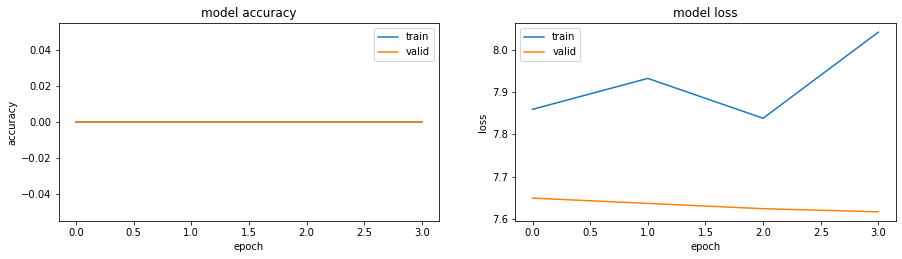


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 54.4564 - accuracy: 0.0000e+00 - precision: 0.0833 - recall: 0.0625 - f1_score: 0.0308

LOSS:	54.456443786621094 	 ACCURACY:	0.0 	 PRECISION:	0.0833333358168602 	 RECALL:	0.0625 	 F1-SCORE:	0.030769232660531998
[54.456443786621094, 0.0, 0.0833333358168602, 0.0625, 0.030769232660531998]



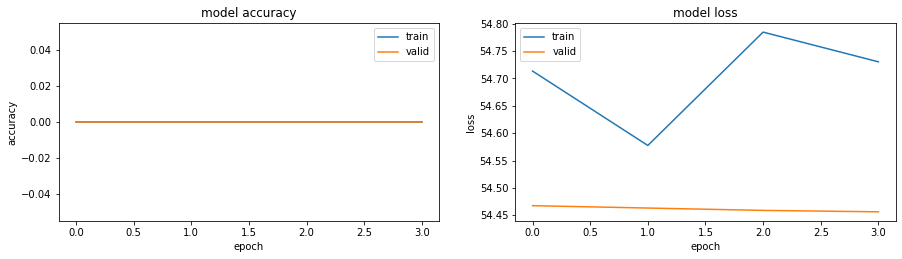


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 1.9442 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.9441790580749512 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.9441790580749512, 0.0, 0.0, 0.0, 0.0]



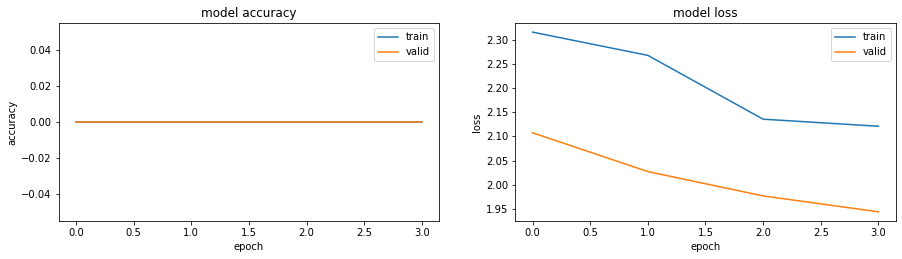


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 166ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 4.2359 - accuracy: 0.0000e+00 - precision: 0.4375 - recall: 0.4375 - f1_score: 0.1217

LOSS:	4.2358622550964355 	 ACCURACY:	0.0 	 PRECISION:	0.4375 	 RECALL:	0.4375 	 F1-SCORE:	0.12173912674188614
[4.2358622550964355, 0.0, 0.4375, 0.4375, 0.12173912674188614]



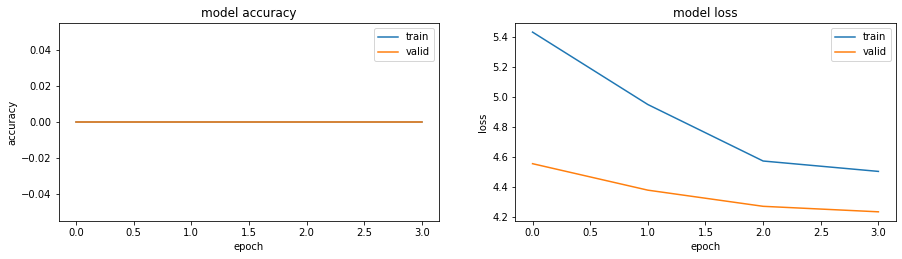


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 166ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 4.1760 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	4.175966262817383 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[4.175966262817383, 0.0, 0.0, 0.0, 0.0]



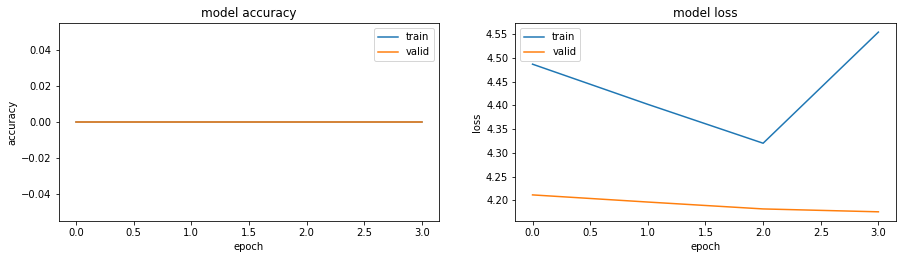


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 1.6845 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.684458613395691 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.684458613395691, 0.0, 0.0, 0.0, 0.0]



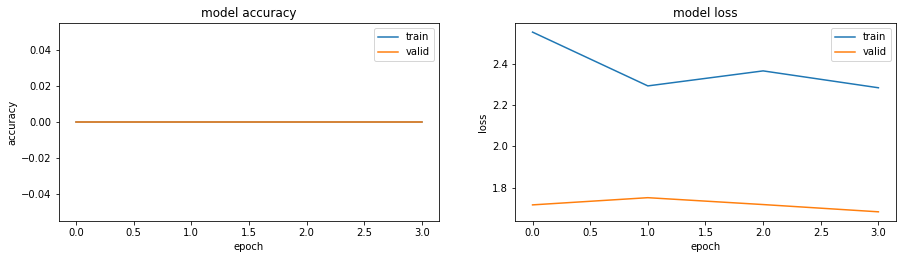


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 187ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 6.8173 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	6.817295074462891 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[6.817295074462891, 0.0, 0.0, 0.0, 0.0]



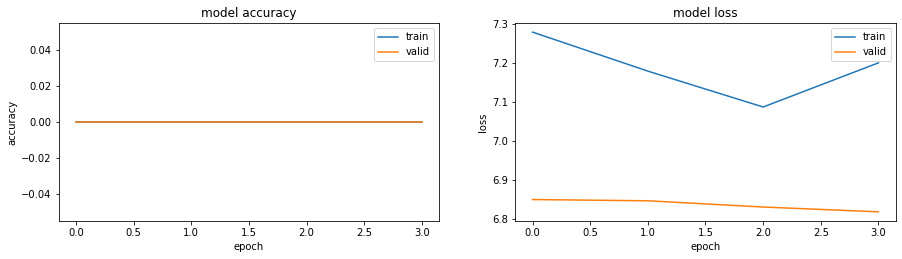


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 170ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 2.8774 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.8774096965789795 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.8774096965789795, 0.0, 0.0, 0.0, 0.0]



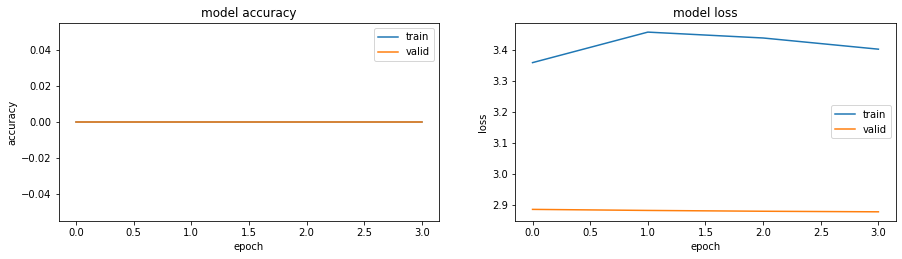


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 177ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 6.0880 - accuracy: 0.0000e+00 - precision: 0.4375 - recall: 0.4375 - f1_score: 0.1217

LOSS:	6.088038444519043 	 ACCURACY:	0.0 	 PRECISION:	0.4375 	 RECALL:	0.4375 	 F1-SCORE:	0.12173912674188614
[6.088038444519043, 0.0, 0.4375, 0.4375, 0.12173912674188614]



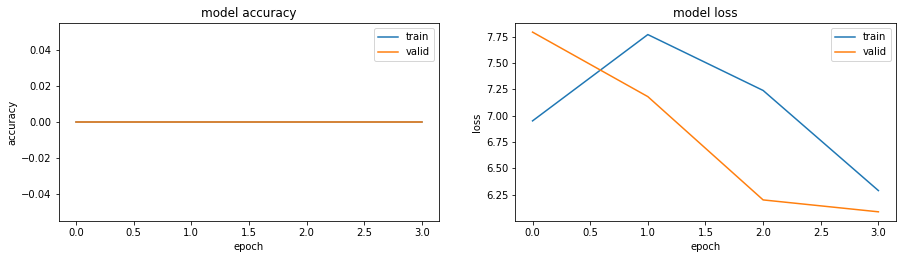


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 37ms/step - loss: 4.7248 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	4.724832534790039 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[4.724832534790039, 0.0, 0.0, 0.0, 0.0]



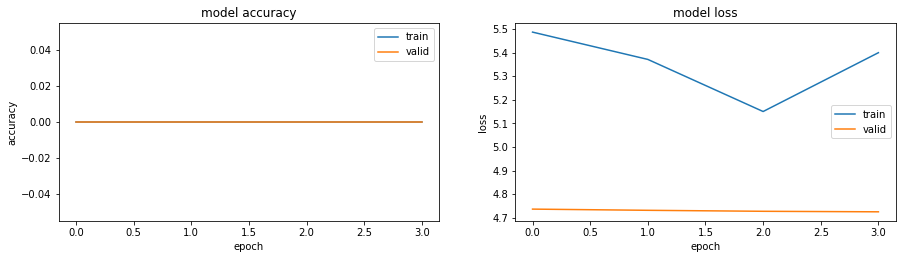


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 184ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 28.3215 - accuracy: 0.0000e+00 - precision: 0.3333 - recall: 0.1250 - f1_score: 0.0800

LOSS:	28.321521759033203 	 ACCURACY:	0.0 	 PRECISION:	0.3333333432674408 	 RECALL:	0.125 	 F1-SCORE:	0.07999999821186066
[28.321521759033203, 0.0, 0.3333333432674408, 0.125, 0.07999999821186066]



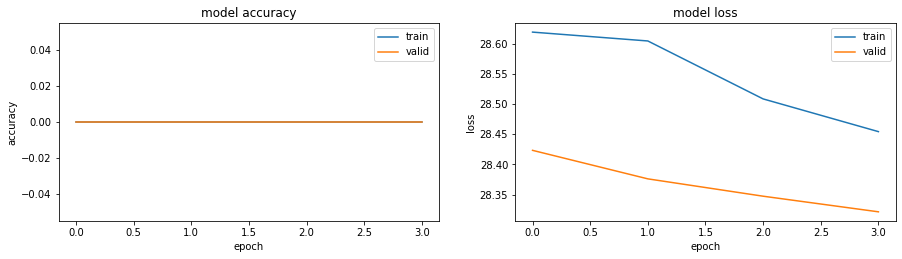


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-02 3.0e+00 5.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 184ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 2.2923 - accuracy: 0.0000e+00 - precision: 0.5385 - recall: 0.4375 - f1_score: 0.1400

LOSS:	2.2922914028167725 	 ACCURACY:	0.0 	 PRECISION:	0.5384615659713745 	 RECALL:	0.4375 	 F1-SCORE:	0.14000001549720764
[2.2922914028167725, 0.0, 0.5384615659713745, 0.4375, 0.14000001549720764]



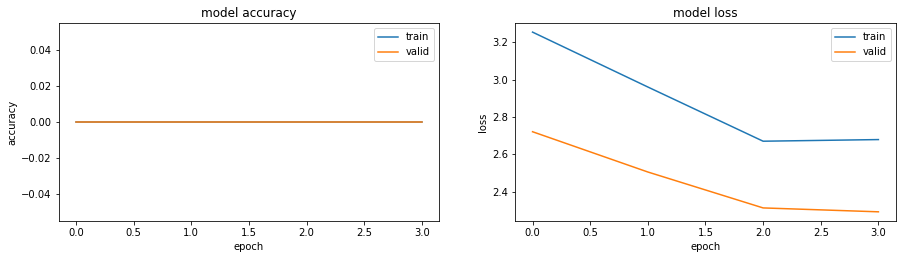


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 4.9174 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	4.917389869689941 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[4.917389869689941, 0.0, 0.0, 0.0, 0.0]



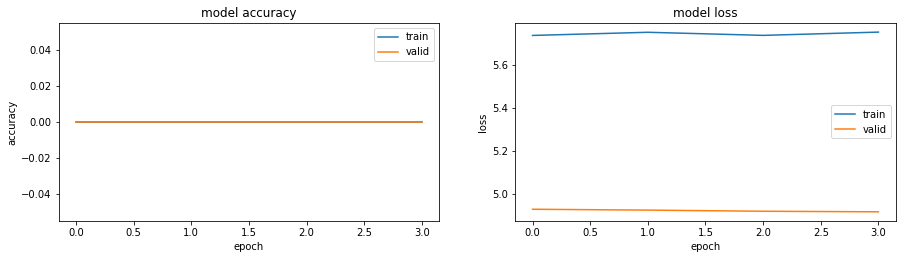


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 186ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 11.4627 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	11.462743759155273 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[11.462743759155273, 0.0, 0.0, 0.0, 0.0]



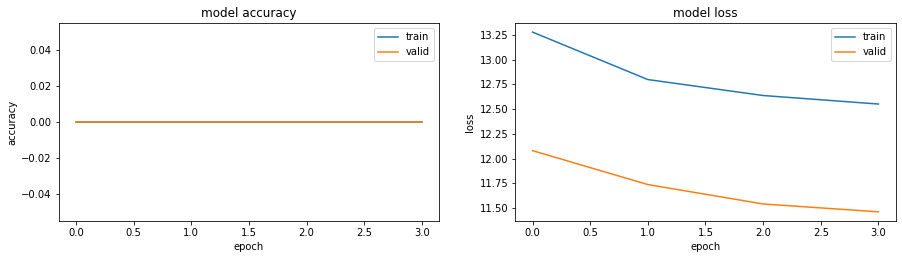


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 7.6379 - accuracy: 0.0000e+00 - precision: 0.5000 - recall: 0.0625 - f1_score: 0.0444

LOSS:	7.637899398803711 	 ACCURACY:	0.0 	 PRECISION:	0.5 	 RECALL:	0.0625 	 F1-SCORE:	0.04444444924592972
[7.637899398803711, 0.0, 0.5, 0.0625, 0.04444444924592972]



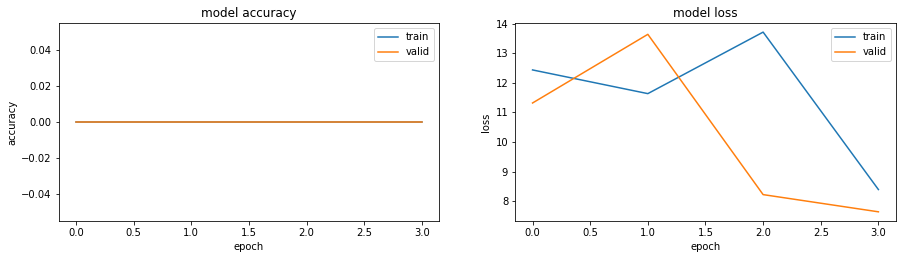


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 166ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 2.4608 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.4607527256011963 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.4607527256011963, 0.0, 0.0, 0.0, 0.0]



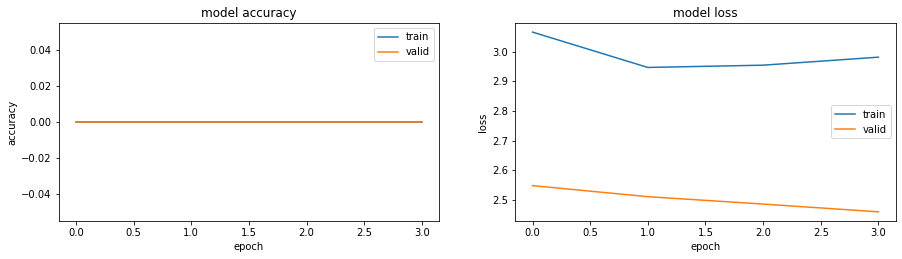


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 175ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 2.5177 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.517669200897217 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.517669200897217, 0.0, 0.0, 0.0, 0.0]



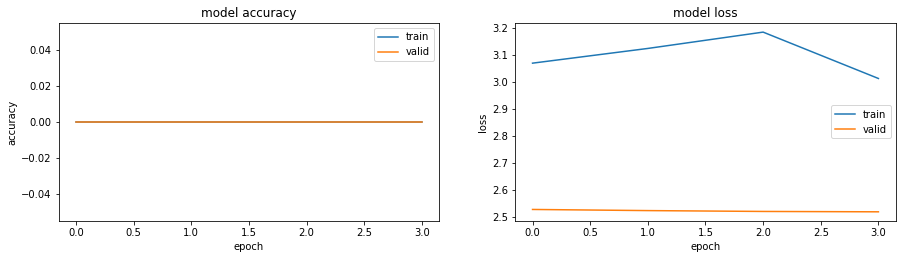


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 3.0e+00 3.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 161ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 15.2544 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	15.254350662231445 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[15.254350662231445, 0.0, 0.0, 0.0, 0.0]



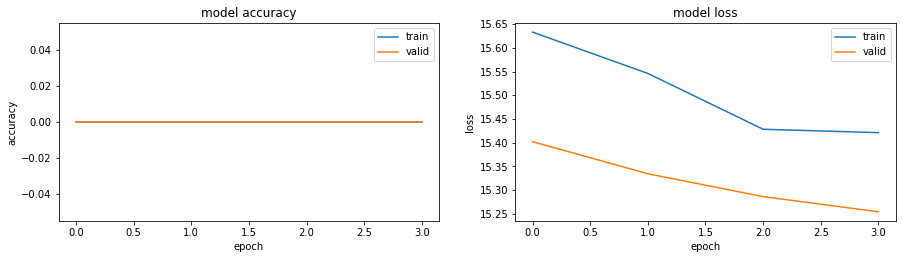


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 174ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 2.4179 - accuracy: 0.0000e+00 - precision: 0.1250 - recall: 0.1250 - f1_score: 0.0444

LOSS:	2.417855978012085 	 ACCURACY:	0.0 	 PRECISION:	0.125 	 RECALL:	0.125 	 F1-SCORE:	0.04444444552063942
[2.417855978012085, 0.0, 0.125, 0.125, 0.04444444552063942]



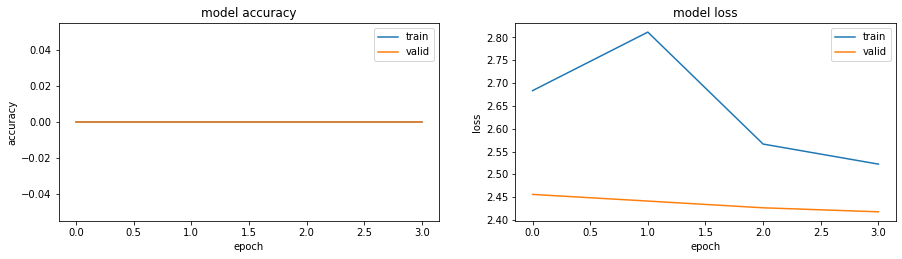


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 1.5366 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.5366424322128296 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.5366424322128296, 0.0, 0.0, 0.0, 0.0]



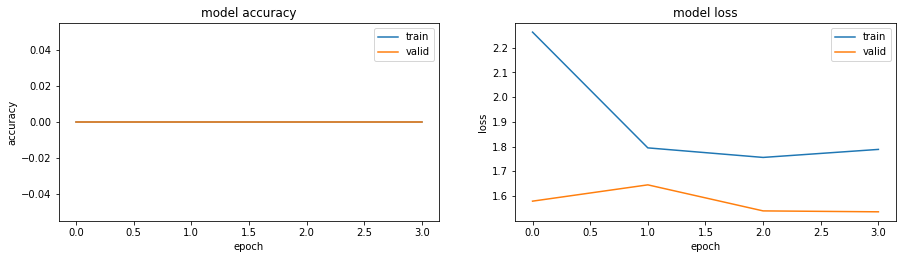


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 177ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 2.3439 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.3438868522644043 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.3438868522644043, 0.0, 0.0, 0.0, 0.0]



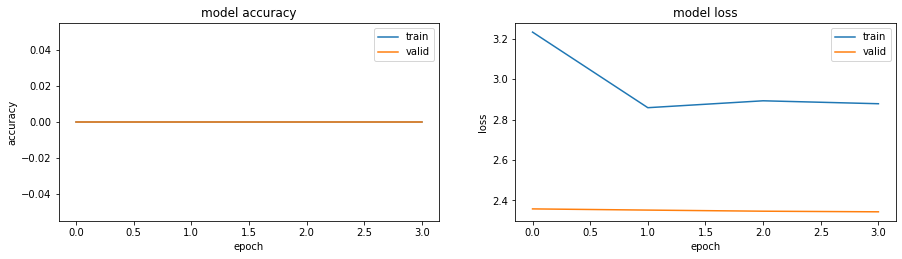


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 184ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 2.9566 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.9565815925598145 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.9565815925598145, 0.0, 0.0, 0.0, 0.0]



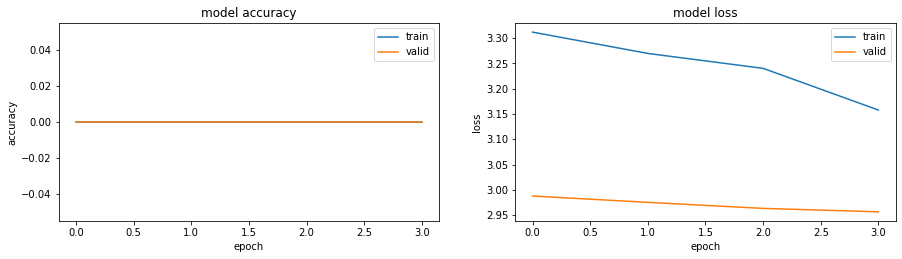


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 11.8610 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	11.860986709594727 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[11.860986709594727, 0.0, 0.0, 0.0, 0.0]



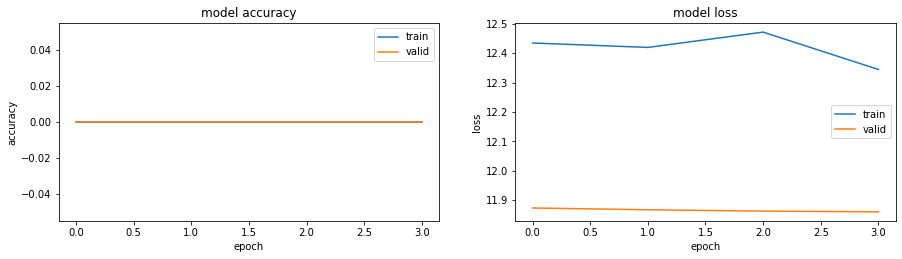


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 170ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 35ms/step - loss: 11.7997 - accuracy: 0.0000e+00 - precision: 0.4615 - recall: 0.3750 - f1_score: 0.1200

LOSS:	11.799738883972168 	 ACCURACY:	0.0 	 PRECISION:	0.4615384638309479 	 RECALL:	0.375 	 F1-SCORE:	0.11999998986721039
[11.799738883972168, 0.0, 0.4615384638309479, 0.375, 0.11999998986721039]



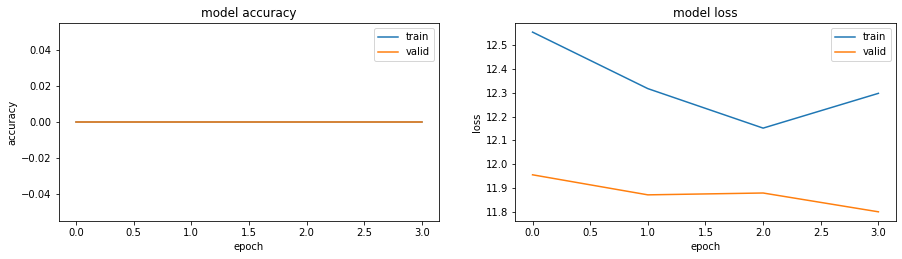


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 39ms/step - loss: 1.6317 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	1.631729006767273 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[1.631729006767273, 0.0, 0.0, 0.0, 0.0]



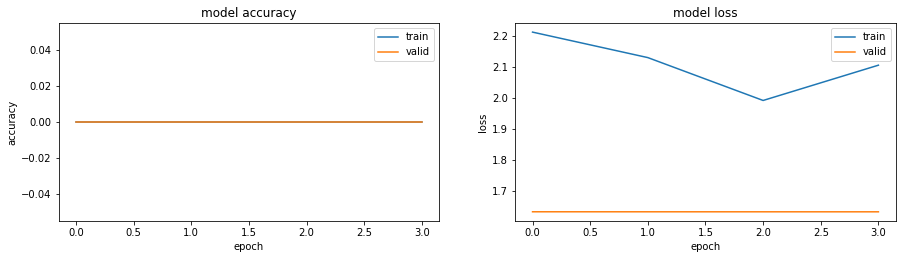


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 191ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 3.3241 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	3.3240532875061035 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[3.3240532875061035, 0.0, 0.0, 0.0, 0.0]



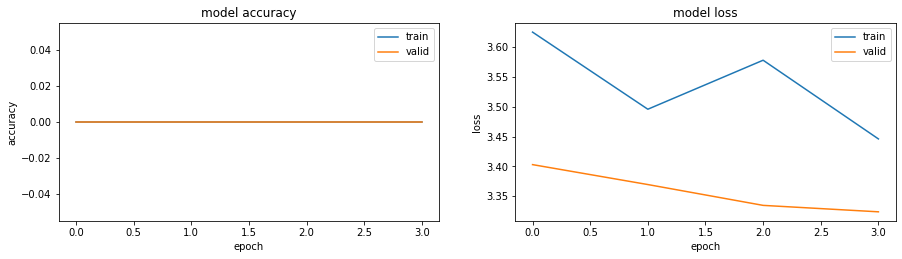


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 7.1472 - accuracy: 0.0000e+00 - precision: 0.4444 - recall: 0.2500 - f1_score: 0.1000

LOSS:	7.147231578826904 	 ACCURACY:	0.0 	 PRECISION:	0.4444444477558136 	 RECALL:	0.25 	 F1-SCORE:	0.10000000149011612
[7.147231578826904, 0.0, 0.4444444477558136, 0.25, 0.10000000149011612]



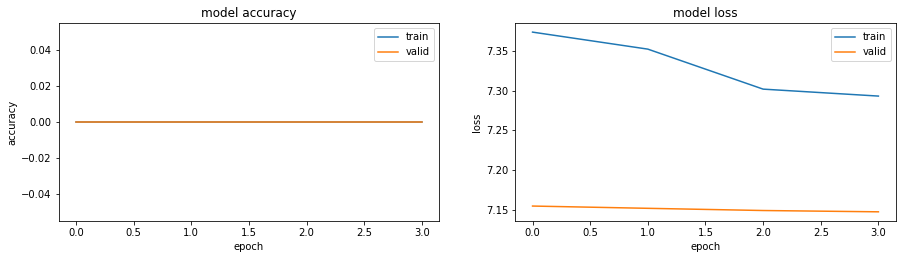


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 52.0317 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	52.03172302246094 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[52.03172302246094, 0.0, 0.0, 0.0, 0.0]



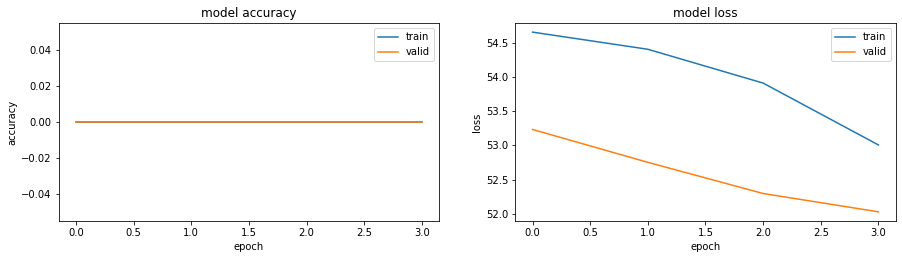


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 166ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 2.8397 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.839660406112671 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.839660406112671, 0.0, 0.0, 0.0, 0.0]



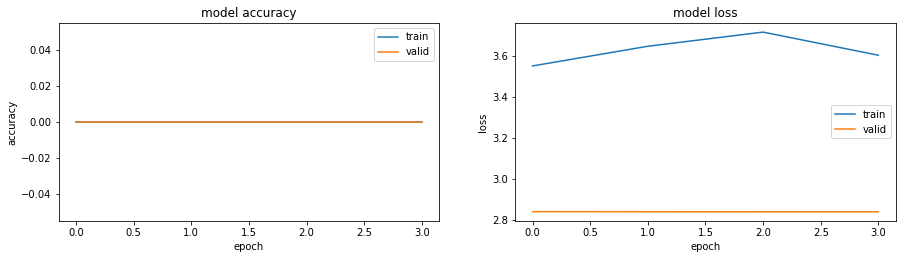


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 3.0e+00 3.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 178ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 42ms/step - loss: 15.2039 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	15.203911781311035 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[15.203911781311035, 0.0, 0.0, 0.0, 0.0]



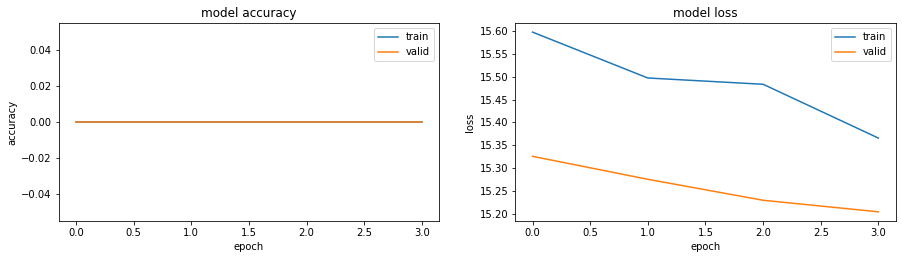


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 104.6846 - accuracy: 0.0000e+00 - precision: 0.4286 - recall: 0.1875 - f1_score: 0.0857

LOSS:	104.68464660644531 	 ACCURACY:	0.0 	 PRECISION:	0.4285714328289032 	 RECALL:	0.1875 	 F1-SCORE:	0.08571428805589676
[104.68464660644531, 0.0, 0.4285714328289032, 0.1875, 0.08571428805589676]



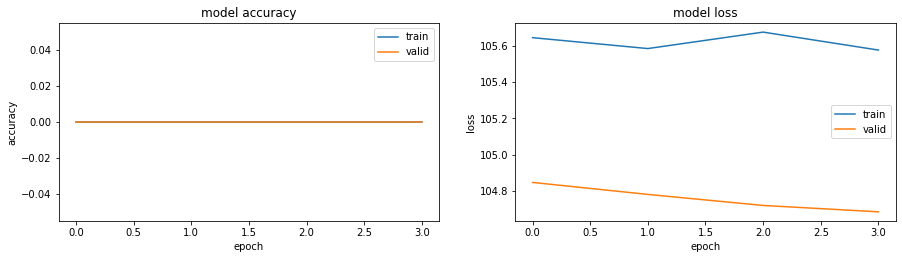


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 1.8657 - accuracy: 0.0000e+00 - precision: 0.5000 - recall: 0.1250 - f1_score: 0.1000

LOSS:	1.8657066822052002 	 ACCURACY:	0.0 	 PRECISION:	0.5 	 RECALL:	0.125 	 F1-SCORE:	0.10000000149011612
[1.8657066822052002, 0.0, 0.5, 0.125, 0.10000000149011612]



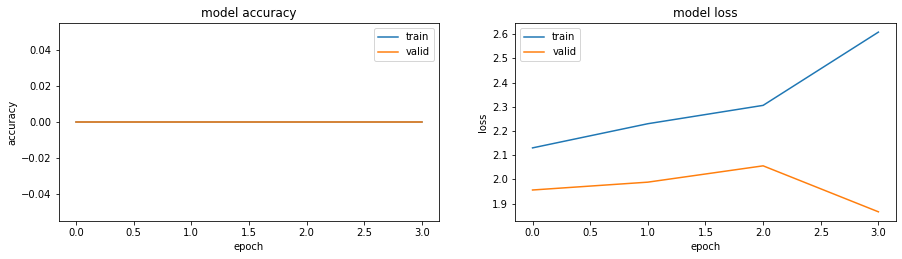


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 164ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 39ms/step - loss: 6.1044 - accuracy: 0.0000e+00 - precision: 0.0625 - recall: 0.0625 - f1_score: 0.0235

LOSS:	6.1044230461120605 	 ACCURACY:	0.0 	 PRECISION:	0.0625 	 RECALL:	0.0625 	 F1-SCORE:	0.0235294122248888
[6.1044230461120605, 0.0, 0.0625, 0.0625, 0.0235294122248888]



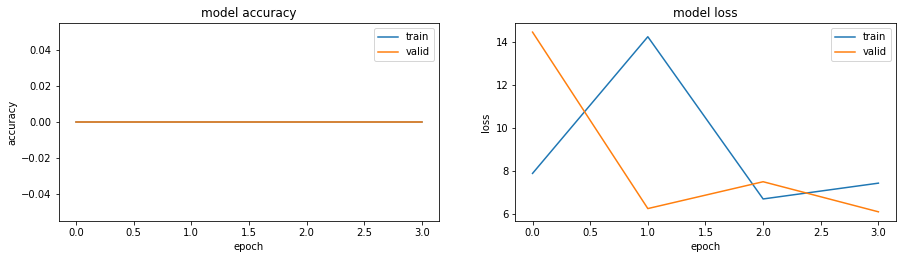


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 173ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 2.0091 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	2.009098768234253 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[2.009098768234253, 0.0, 0.0, 0.0, 0.0]



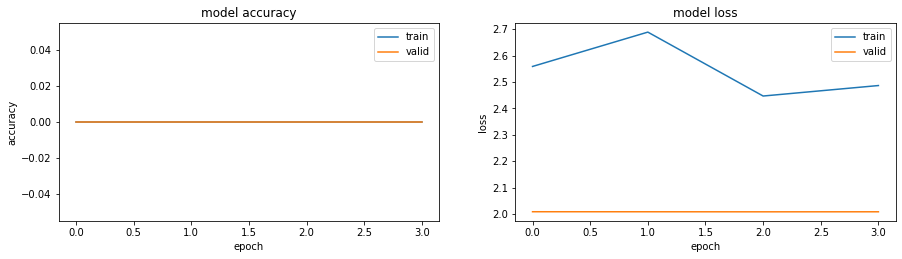


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 179ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 53.1269 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	53.12685775756836 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[53.12685775756836, 0.0, 0.0, 0.0, 0.0]



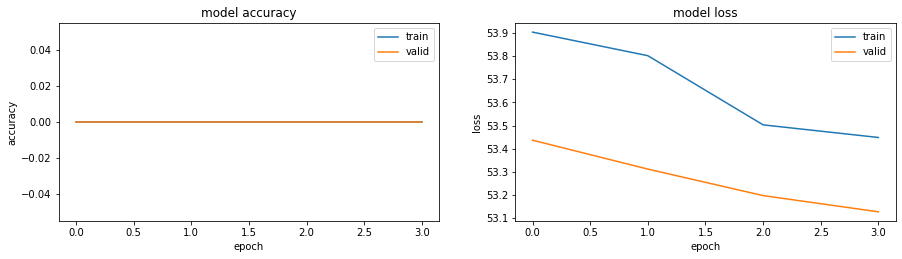


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 193ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 15.9805 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00

LOSS:	15.980514526367188 	 ACCURACY:	0.0 	 PRECISION:	0.0 	 RECALL:	0.0 	 F1-SCORE:	0.0
[15.980514526367188, 0.0, 0.0, 0.0, 0.0]



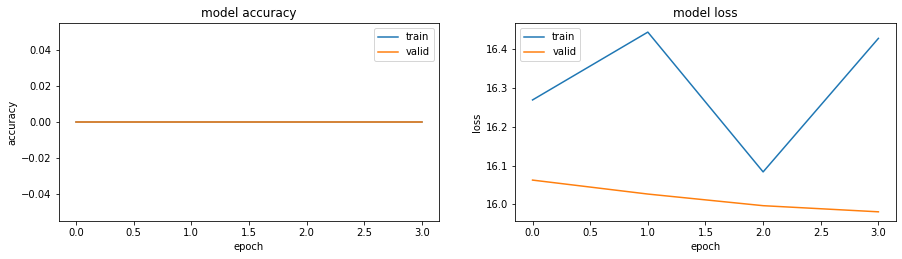


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 181ms/step - loss: 2.0707 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 4.0571 - accuracy: 0.0000e+00 - precision: 0.1250 - recall: 0.1250 - f1_score: 0.0444

LOSS:	4.057149887084961 	 ACCURACY:	0.0 	 PRECISION:	0.125 	 RECALL:	0.125 	 F1-SCORE:	0.04444444552063942
[4.057149887084961, 0.0, 0.125, 0.125, 0.04444444552063942]



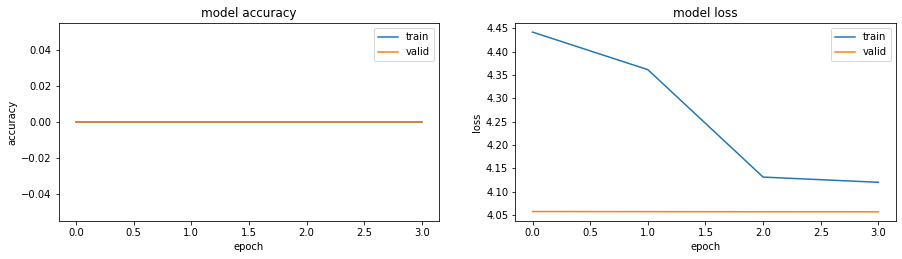

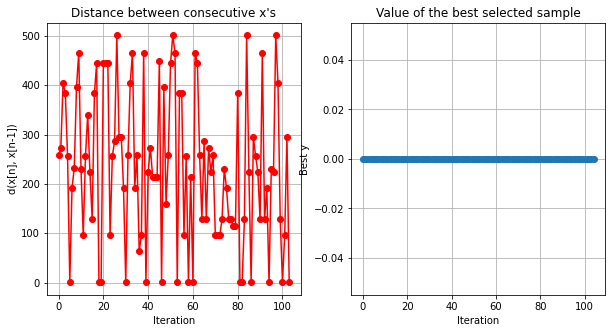

In [41]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('DR_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0],
  evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'DR_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [42]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	128.0
	learning_rate:	1e-05
	l2:	0.1
	activation:	tanh
	rate:	0.5
	batch:	256.0
 optim SGD
optimized accuracy: [0.]


In [43]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('DR_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 493,061
Trainable params: 493,061
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 160ms/step - loss: 2.0707 - accuracy: 0.5000
Restored model, accuracy: 50.00%


In [44]:
best_model.evaluate(features_valid, y_test)

1/1 [==============================] - 0s 24ms/step - loss: 2.0707 - accuracy: 0.5000


[2.0707337856292725, 0.5]

In [45]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Sat May 28 21:15:59 2022
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           331.17891097068787 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition o

Test model with test data

In [46]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [48]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [49]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

2/2 [==============================] - 0s 10ms/step - loss: 2.0946 - accuracy: 0.4222
Restored model, accuracy: 42.22%


In [50]:
best_model.evaluate(features_test, y_test)

2/2 [==============================] - 0s 36ms/step - loss: 2.0946 - accuracy: 0.4222


[2.0946216583251953, 0.42222222685813904]